## Objective:
- Fit a One vs All classifier for for different types of variable stars
- Use several different classifier methods: XG Boost, Random Forest, Decision Tree, Logistic Regression, Naive Bayes
- Create a comparision table for different classifiers and labels. Compare using metrics like accuracy, precision and recall

In [1]:
#Load libraries
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle # allows to save differnt trained models of the same classifier object
import seaborn as sns

## Complete features and label table from Xiadian's website

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('../databases/Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('../databases/Labeled_data.txt', header=None, delim_whitespace=True, skiprows=36) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
label = labeled_data.Type.unique()
label = np.delete(label, np.where(label == 'CEPII')) # CEPII has very few samples so we ignore it
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'Mira' 'RRc' 'CEP']


## Glossary of different type of variable stars

The 11 different types of variable stars in the data are as follows:
1. <strong> BYDra </strong> : BY Draconis variables are variable stars of late spectral types, usually K or M, and typically belong to the main sequence. 
1. <strong> EW</strong> : EW-type eclipsing binaries (EWs) are W Ursae Majoris-type eclipsing variables with periods shorter than one day.
1. <strong> SR</strong> : semi-regular variables
1. <strong> RSCVN</strong> : An RS Canum Venaticorum variable is a type of variable star. The variable type consists of close binary stars having active chromospheres which can cause large stellar spots.
1. <strong> RR</strong> :RR Lyrae variables are periodic variable stars, commonly found in globular clusters. They are used as standard candles to measure (extra) galactic distances, assisting with the cosmic distance ladder. 
1. <strong> DSCT</strong>: A Delta Scuti variable (sometimes termed dwarf cepheid when the V-band amplitude is larger than 0.3 mag.) is a subclass of young pulsating star. These variables as well as classical cepheids 
1. <strong> EA</strong> : Algol (Beta Persei)-type eclipsing systems. Binaries with spherical or slightly ellipsoidal components. 
1. <strong> Mira</strong> : Mira variables are a class of pulsating stars characterized by very red colours, pulsation periods longer than 100 days, and amplitudes greater than one magnitude in infrared and 2.5 magnitude at visual wavelengths. 
1. <strong> RRc</strong> : RR Lyrae variable stars of subclass c. 
1. <strong> CEP</strong> : A Cepheid variable is a type of star that pulsates radially, varying in both diameter and temperature and producing changes in brightness with a well-defined stable period and amplitude. 
1. <strong> CEPII</strong> : Type II Cepheids are variable stars which pulsate with periods typically between 1 and 50 days. They are population II stars: old, typically metal-poor, low mass objects.

## Import features extracted from light curves
These features are caluclated on 1000 light curves of each variable type. The light curves are imported from variables.cn:88/ . The features are calculated and stored in a .csv file for later use. The .csv file is loaded and used for training the classifier. Below is a brief description of the features calculated to train the models.
Feature list
- <strong>mean</strong> : mean of the light curve
- <strong>wmean</strong> : weight mean of the light curve
- <strong>MAD</strong> : deviation about the median
- <strong>IQR</strong> : inter quartile percentile of the light curve
- <strong>f60</strong> : 60 percentile  of light curve
- <strong>f70</strong> : 70 percentile of the light curve
- <strong>f80</strong> : 80 percentile of the light curve
- <strong>f90</strong> : 90 percentile of the light curve
- <strong>skew</strong> : skewness of the light curve
- <strong>kurtosis</strong> : kurtosis of the light curve
- <strong>welsk_k, welsh_j</strong> : welsh and staton J and K statistics of the light curve
- <strong>g_</strong> : g band filter
- <strong>r_</strong> : r band filter

In [3]:
df = pd.read_csv('../features/features10000-2.csv', header=None, skiprows=1)
header = pd.read_csv('../features/features10000-2.csv', header=None, nrows=1)
df.columns = header.iloc[0]

In [4]:
df.head()

0  sourceid                      ID     RAdeg      DEdeg     g_mean  \
0       1.0  ZTFJ000000.13+620605.8  0.000566  62.101631  17.994656   
1       2.0  ZTFJ000000.14+721413.7  0.000620  72.237174  19.619402   
2       3.0  ZTFJ000000.19+320847.2  0.000795  32.146449  15.313984   
3       4.0  ZTFJ000000.26+311206.3  0.001085  31.201756  16.353295   
4       6.0  ZTFJ000000.30+233400.5  0.001249  23.566828  17.892283   

0    g_wmean  g_MAD    g_IQR   g_f60    g_f70  ...    r_IQR   r_f60    r_f70  \
0  17.992102  0.034  0.07000  0.0820  0.10000  ...  0.05125  0.0580  0.06655   
1  19.579923  0.111  0.22650  0.2850  0.35950  ...  0.22750  0.2712  0.30765   
2  15.313984  0.072  0.14200  0.1580  0.18300  ...  0.12600  0.1470  0.16080   
3  16.353295  0.077  0.14900  0.1710  0.18700  ...  0.10200  0.1322  0.15980   
4  17.878715  0.102  0.18975  0.2526  0.28225  ...  0.22900  0.2700  0.29620   

0   r_f80    r_f90    r_skew  r_kurtosis  r_welsh_J  r_welsh_K   Type  
0  0.0797  0.09370  0.105202   -0.632720   0.000801  -0.272584  BYDra  
1  0.3614  0.44115  0.334634   -0.775188   0.017220  -1.523362     EW  
2  0.1760  0.18860 -0.212606   -1.485137   0.004299   0.547045     EW  
3  0.1946  0.20560  0.418285   -1.009552   0.004143  -0.029302     EW  
4  0.3132  0.33620  0.158998   -1.484462   0.013482  -0.366492     EW  

[5 rows x 29 columns]

In [5]:
# Drop rows with Blank values
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(level=None, drop=False, inplace=True)

In [6]:
# get all unique labels
label = df.Type.unique()
print(label)

['BYDra' 'EW' 'SR' 'RSCVN' 'RR' 'DSCT' 'EA' 'RRc' 'Mira' 'CEP']


<AxesSubplot:xlabel='Type', ylabel='Count'>

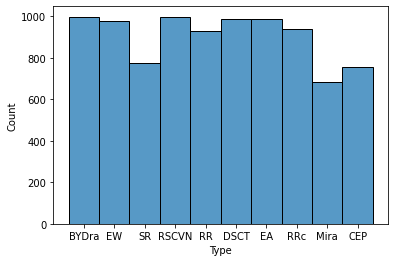

In [7]:
# Plot histogram of variable types in the dataset

sns.histplot(data=df, x=df.Type)

## Various functions to create multiple classifiers

In [8]:
def multiple_to_2labels(df,variable_type):
    """
    converts multiple labels for diffrent variable types to only two labels for one vs all classifier.
    Returns 2 data frames: 
    1. Original data frame with new labels. 
    2. Dataframe with equal candidates of the two classes.
    """
    OneClass = variable_type
    df0 = df.copy()
    df0.loc[df0.Type != OneClass,'Type'] = 'ZZ'
    df1 = df0[df0.Type == 'ZZ']
    df2 = df0[df0.Type == OneClass]

    df3 = df1.sample(n=6000, random_state=1) # balance data type by only selecting 1000 of other type
    frames = [df2,df3]
    df_balanced = pd.concat(frames)
    return df0, df_balanced

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
def preprocess_data(df):
    """
    Preprocess data for one vs all classifier and split it to train/test data
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df
    # Encode labels to form y labels
    y = le.transform(df.Type)

    # Split dataset into training set and test set
    X_tr, X_ts, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
    X_train = X_tr.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    X_test = X_ts.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    return X_train, X_test, y_train, y_test
    

In [10]:

from sklearn import metrics
# from sklearn.metrics import confusion_matrix
def oneVSall_classiffier(name,model,X_train, X_test, y_train, y_test):
    """
    Train Classifier using train dataset. Calculate classifier metrics using test dataset
    """
    #Train the model using the training sets 
    if name == ("Isolation Forest" or "One Class SVM"):
        X_train = X_train[y_train==0]
        model.fit(X_train)
    else:
        model.fit(X_train,y_train)

    # Predict test data output
    y_pred = model.predict(X_test)
    
    # Estimate model performance on test data
    if name == "Isolation Forest" or "One Class SVM":
        one_index = np.where(y_pred==1)
        y_pred[one_index] = 1
        negone_index = np.where(y_pred==-1)
        y_pred[negone_index] = 0
    accuracy = metrics.accuracy_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
                                      
    return model, accuracy, precision, recall, confusion

## Function to create heat maps

In [11]:
# A simple categorical heatmap
# code from : https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Train and Compare Classifiers

In [12]:
# list of classification methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import OneClassSVM

# names = ["Isolation Forest", "One Class SVM", "XG Boost","Random Forest", "Decision Tree", "Logistic Regression", "Naive Bayes"]
clf_names = ["XGBoost","RandomForest", "DecisionTree", "LogisticRegression", "NaiveBayes"]

classifiers = [
#     IsolationForest(contamination=0.01),
#     OneClassSVM(gamma='scale', nu=0.01),
    XGBClassifier(use_label_encoder=False),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(criterion="gini", max_depth=3),
    LogisticRegression(solver = 'liblinear',max_iter = 500),
    GaussianNB()]
    


In [13]:
# Run loop to train all classifiers and collect metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}
fitted_models={}

# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric(avg)'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)
for name in clf_names:
    accuracy[name] = {}
    precision[name] = {}
    recall[name] = {}
    confusion[name] ={}
    fitted_models[name]={}

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    for p in range(1,2): # train each classification 10 times for each variable type
        df0, df_balanced = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df_balanced)
        for name, clf in zip(clf_names, classifiers): # loop over different classifiers
            print(name)
            clf, accuracy_int, precision_int,recall_int, confusion_int  = oneVSall_classiffier(name,clf,X_train, X_test, y_train, y_test)
            # calculate average accuracy, precision and recall
            if p == 1:
                accuracy[name][variable_type] = 0
                precision[name][variable_type] = 0
                recall[name][variable_type] = 0
            accuracy[name][variable_type] = accuracy_int/p + accuracy[name][variable_type]*(p-1)/p
            precision[name][variable_type] = precision_int/p + precision[name][variable_type]*(p-1)/p
            recall[name][variable_type] =recall_int/p + recall[name][variable_type]*(p-1)/p
            
            confusion[name][variable_type] = confusion_int # save confusion only of the 10th iteration
            fitted_models[name][variable_type] = pickle.dumps(clf) # save model only of the 10th iteration
#             filename = '../pickles/'+name+'_'+variable_type+'.pkl'
#             pickle.dump(clf, open(filename, 'wb'))
for name in clf_names:        
    pd_comparison.loc[:,(name,'acc.')] = list(accuracy[name].values())
    pd_comparison.loc[:,(name,'preci.')] = list(precision[name].values())
    pd_comparison.loc[:,(name,'recall')] = list(recall[name].values())
    


BYDra
XGBoost
[21:15:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RandomForest
DecisionTree
LogisticRegression
NaiveBayes
EW
XGBoost
[21:15:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RandomForest
DecisionTree
LogisticRegression
NaiveBayes
SR
XGBoost
[21:15:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Random

In [14]:
# print the comparision table
pd_comparison_rounded = pd_comparison.round(decimals=2)
pd_comparison_rounded.head(20)

classifier  XGBoost               RandomForest               DecisionTree  \
metric(avg)    acc. preci. recall         acc. preci. recall         acc.   
BYDra          0.88   0.91   0.95         0.87   0.90   0.96         0.86   
EW             0.92   0.94   0.97         0.92   0.93   0.98         0.89   
SR             0.95   0.96   0.99         0.95   0.95   0.99         0.91   
RSCVN          0.88   0.91   0.95         0.89   0.91   0.97         0.87   
RR             0.95   0.97   0.98         0.95   0.96   0.98         0.92   
DSCT           0.90   0.92   0.96         0.90   0.91   0.98         0.86   
EA             0.98   0.99   0.98         0.98   0.99   0.98         0.97   
RRc            0.96   0.96   0.99         0.94   0.95   0.99         0.92   
Mira           1.00   1.00   1.00         1.00   1.00   1.00         1.00   
CEP            0.97   0.98   0.99         0.96   0.96   0.99         0.90   

classifier                LogisticRegression               NaiveBayes         \
metric(avg) preci. recall               acc. preci. recall       acc. preci.   
BYDra         0.86   0.99               0.87   0.87   0.99       0.54   0.98   
EW            0.93   0.94               0.87   0.87   1.00       0.31   0.99   
SR            0.92   0.99               0.94   0.94   0.99       0.24   0.95   
RSCVN         0.87   0.99               0.86   0.86   1.00       0.54   0.98   
RR            0.94   0.97               0.95   0.96   0.98       0.68   0.99   
DSCT          0.88   0.97               0.87   0.89   0.98       0.44   0.98   
EA            0.99   0.98               0.97   0.98   0.98       0.47   0.99   
RRc           0.92   0.99               0.93   0.95   0.98       0.68   0.99   
Mira          1.00   1.00               1.00   1.00   1.00       0.99   1.00   
CEP           0.91   0.99               0.96   0.97   0.99       0.48   0.98   

classifier          
metric(avg) recall  
BYDra         0.47  
EW            0.20  
SR            0.15  
RSCVN         0.48  
RR            0.63  
DSCT          0.36  
EA            0.38  
RRc           0.63  
Mira          0.99  
CEP           0.43

## Scaled Feature importance for each one vs all classifier XG Boost Classifiers

In [15]:
# create tabe of feature importance
pd_feature = pd.DataFrame(columns=label,index=X_train.columns.values)
for variable_type in label:
    clf_XGBoost =  pickle.loads(fitted_models['XGBoost'][variable_type])
    pd_feature[variable_type] = clf_XGBoost.feature_importances_/max(clf_XGBoost.feature_importances_)

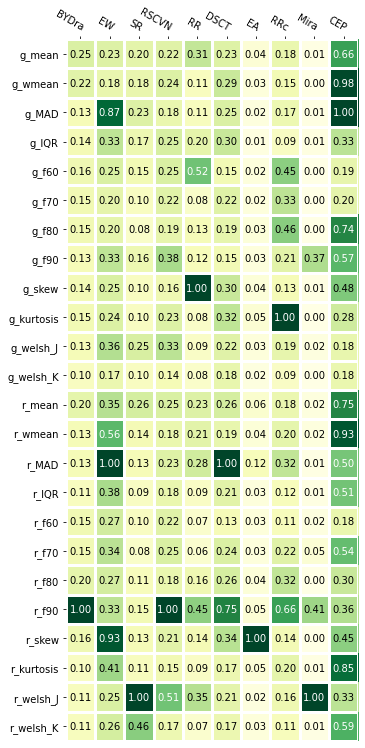

In [16]:
feature_imp = pd_feature.to_numpy()
xlabel = pd_feature.columns.values
ylabel = pd_feature.index.values
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
im = heatmap(feature_imp, ylabel, xlabel, ax=ax,
                   cmap="YlGn", cbarlabel="Scaled feature importance")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [17]:
# feature importance in table format
pd_feature.head(25)

BYDra        EW        SR     RSCVN        RR      DSCT  \
g_mean      0.246015  0.233933  0.204108  0.222182  0.311992  0.227852   
g_wmean     0.218355  0.181943  0.180286  0.238080  0.105895  0.293722   
g_MAD       0.127417  0.872260  0.233487  0.176807  0.110227  0.245451   
g_IQR       0.139809  0.325069  0.165154  0.254982  0.199364  0.298266   
g_f60       0.156295  0.248129  0.147958  0.249208  0.519375  0.145040   
g_f70       0.150588  0.200765  0.102328  0.219319  0.079767  0.223978   
g_f80       0.149977  0.199001  0.078642  0.189482  0.132148  0.191911   
g_f90       0.128284  0.327379  0.164109  0.382886  0.121824  0.145832   
g_skew      0.144415  0.248448  0.101585  0.159324  1.000000  0.298889   
g_kurtosis  0.147456  0.239137  0.098601  0.231843  0.082862  0.323402   
g_welsh_J   0.129115  0.357265  0.250405  0.332880  0.086637  0.222642   
g_welsh_K   0.102858  0.172550  0.101767  0.135472  0.076375  0.184728   
r_mean      0.197426  0.349015  0.264548  0.247370  0.232059  0.261024   
r_wmean     0.128939  0.563503  0.138692  0.176893  0.214542  0.185797   
r_MAD       0.129463  1.000000  0.125354  0.228271  0.275710  1.000000   
r_IQR       0.109010  0.384203  0.094175  0.176461  0.092806  0.211892   
r_f60       0.153114  0.271613  0.100902  0.221757  0.068919  0.128217   
r_f70       0.149946  0.337032  0.079082  0.248571  0.063076  0.242908   
r_f80       0.196712  0.266051  0.113703  0.177259  0.159701  0.261392   
r_f90       1.000000  0.328664  0.147583  1.000000  0.447269  0.754979   
r_skew      0.157553  0.929921  0.129169  0.211290  0.140606  0.341284   
r_kurtosis  0.099804  0.409031  0.109946  0.149836  0.091185  0.171143   
r_welsh_J   0.111952  0.248211  1.000000  0.513594  0.350571  0.205765   
r_welsh_K   0.112459  0.264132  0.458304  0.165737  0.065746  0.170062   

                  EA       RRc      Mira       CEP  
g_mean      0.043992  0.178303  0.005225  0.656888  
g_wmean     0.029173  0.147859  0.002047  0.983953  
g_MAD       0.023044  0.165026  0.009549  1.000000  
g_IQR       0.014600  0.094947  0.014033  0.334108  
g_f60       0.024293  0.452309  0.003169  0.187779  
g_f70       0.024980  0.331304  0.001711  0.203134  
g_f80       0.031481  0.459481  0.001326  0.744976  
g_f90       0.025397  0.213805  0.367941  0.568959  
g_skew      0.035940  0.133431  0.008672  0.482935  
g_kurtosis  0.052962  1.000000  0.002901  0.277983  
g_welsh_J   0.030239  0.188759  0.015951  0.184572  
g_welsh_K   0.018963  0.090846  0.002883  0.177989  
r_mean      0.064841  0.175513  0.022159  0.745092  
r_wmean     0.036391  0.198797  0.019631  0.931658  
r_MAD       0.119409  0.317964  0.005257  0.501497  
r_IQR       0.027155  0.116952  0.008866  0.511672  
r_f60       0.030414  0.113766  0.018017  0.177183  
r_f70       0.027103  0.219074  0.047601  0.539190  
r_f80       0.036551  0.317501  0.000000  0.300230  
r_f90       0.045570  0.657897  0.409833  0.362424  
r_skew      1.000000  0.142036  0.001170  0.449378  
r_kurtosis  0.045839  0.195319  0.008021  0.847476  
r_welsh_J   0.020064  0.163837  1.000000  0.334943  
r_welsh_K   0.027652  0.114149  0.006761  0.594236

## Visualize prediction output of all XG Boost classifiers on the whole dataset

In [18]:
pd_comparison.to_csv('comparison_unbalanced.csv')

In [19]:
def preprocess_data2(df):
    """
    Preprocess data for one vs all classifier.
    Return the features dataframe and labels
    """
    # Map string labels to numbers
    label = df.Type

    le = preprocessing.LabelEncoder()
    le.fit(label)

    # Drop columns that are not features
    X = df.drop(['index','Type','sourceid', 'RAdeg','DEdeg','ID'],axis='columns')
    # Encode labels to form y labels
    y = le.transform(df.Type)
    return X, y

In [20]:
def find_probabilities(fitted_models,df,variable_type):
    """
    Push all the data through a 1 vs all classfier. 
    Return the classification probabilities in the two clsses
    """
    df0,df_oneVsAll = multiple_to_2labels(df,variable_type)
    X, y = preprocess_data2(df0)
    clf_XGBoost =  pickle.loads(fitted_models['XGBoost'][variable_type])
    clf_XGBoost =  pickle.loads(fitted_models['XGBoost'][variable_type])
#     print(clf_XGBoost.feature_importances_)
    y_prob = clf_XGBoost.predict_proba(X)
    return y_prob

In [21]:
# iterate over 1 vs all XG Boost classifiers for all varaibles and find probabilities
all_probs={}
for variable_type in label:
#     print(variable_type)
    all_probs[variable_type] = find_probabilities(fitted_models,df,variable_type)

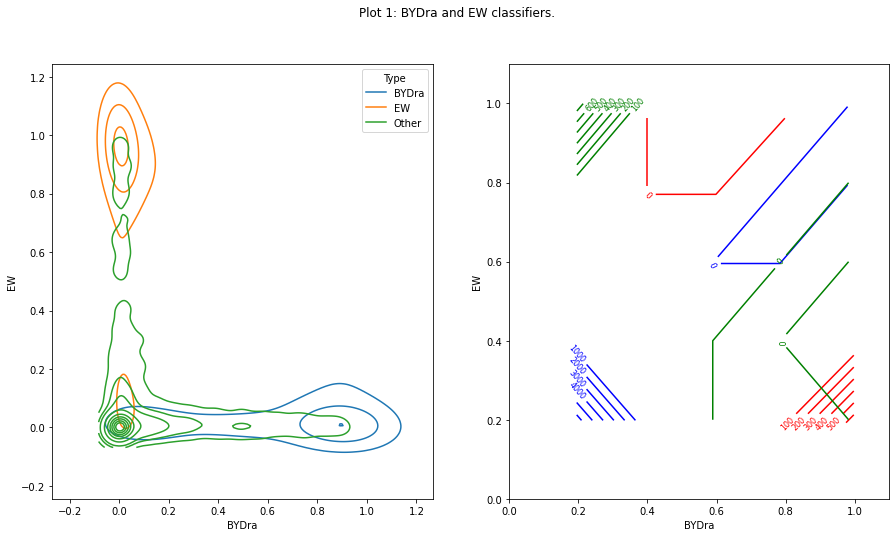

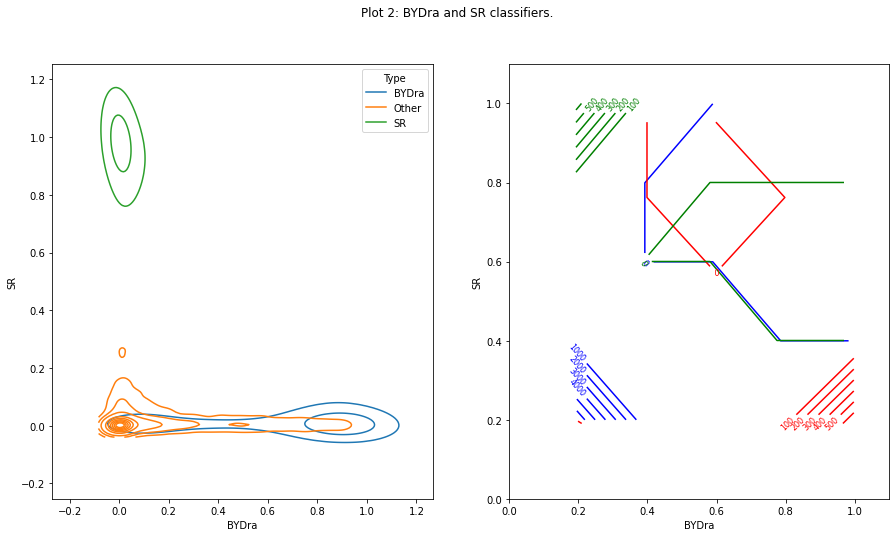

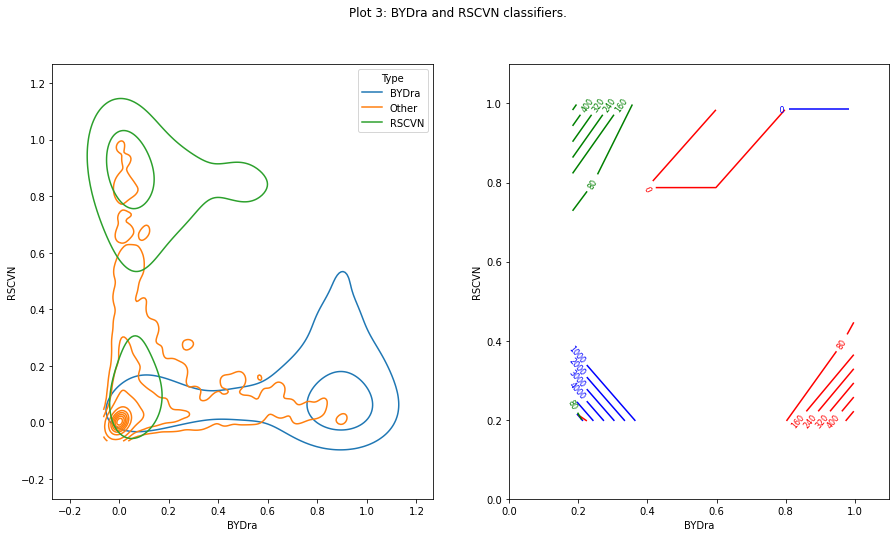

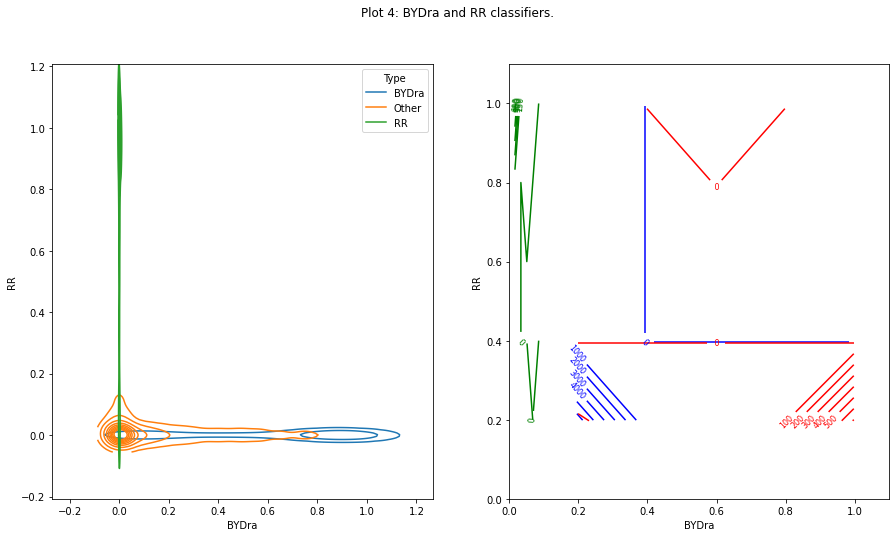

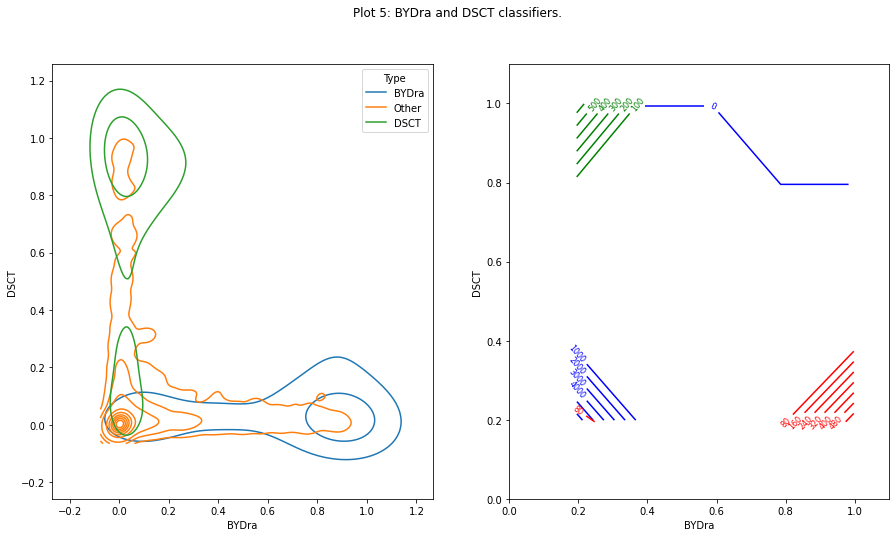

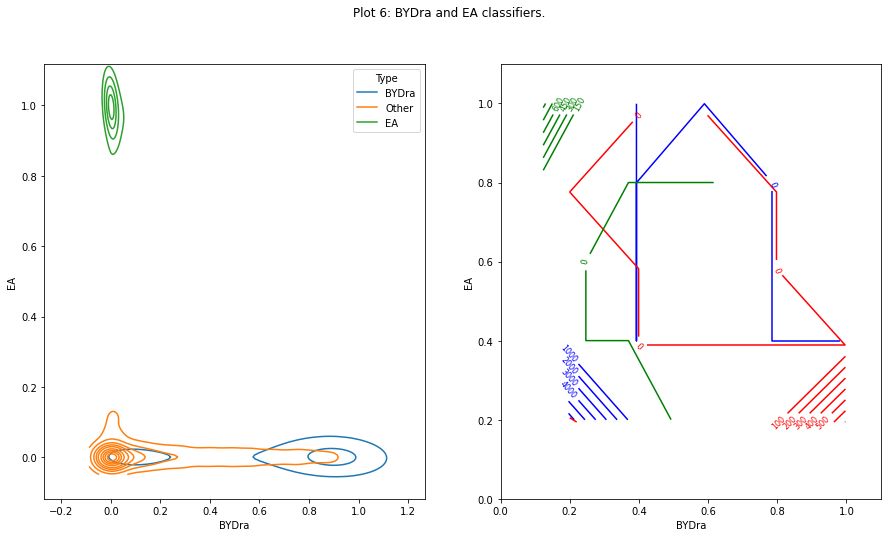

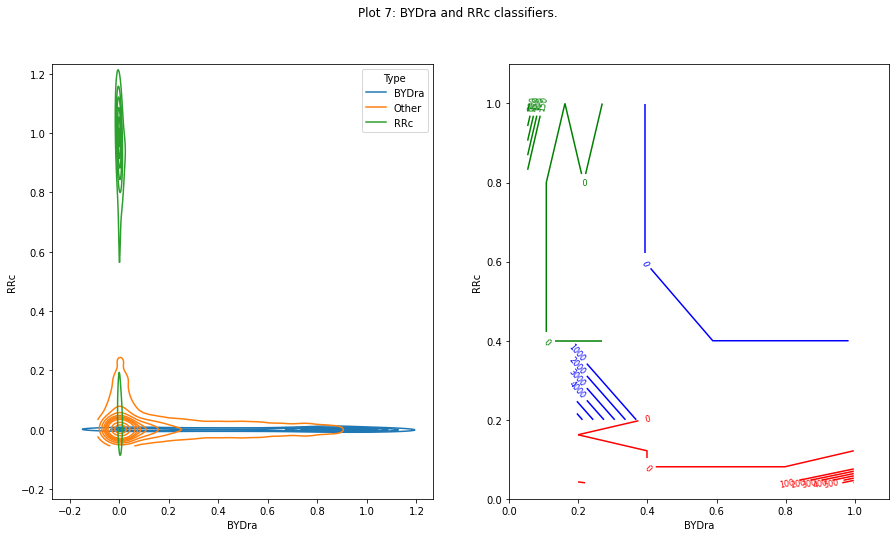

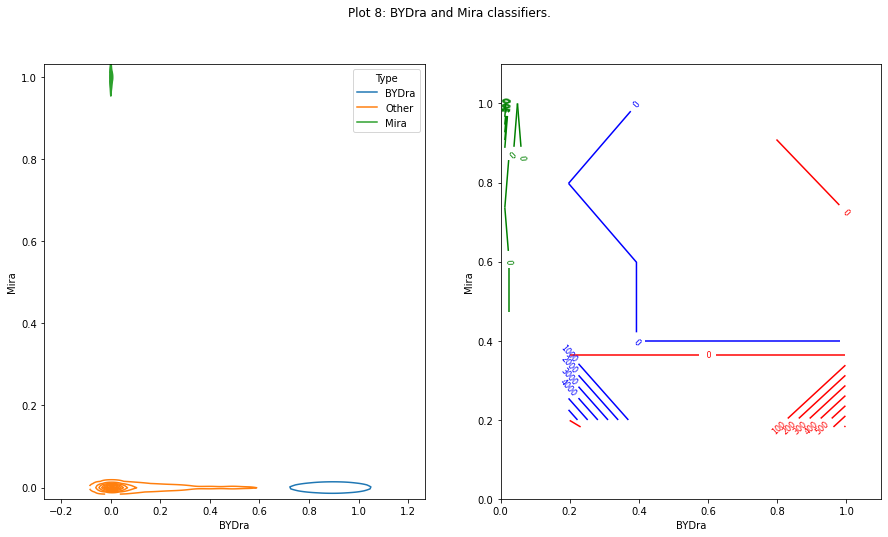

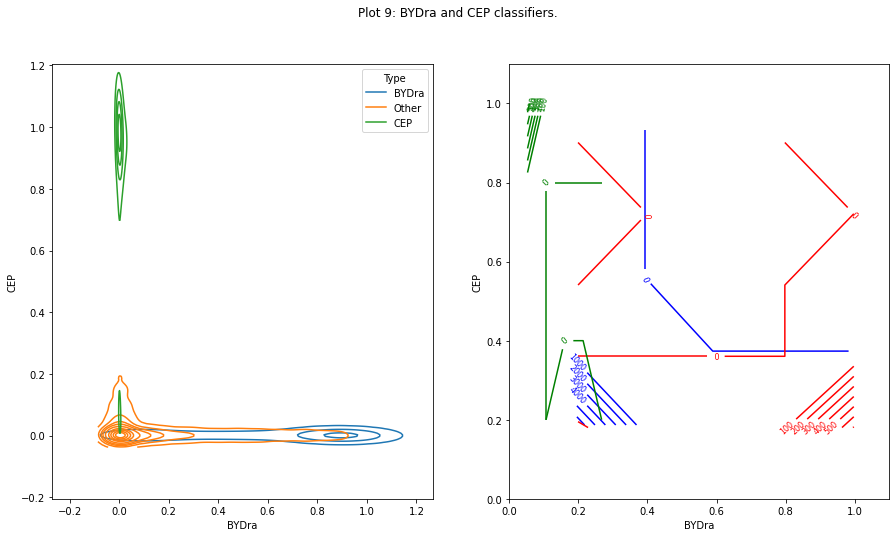

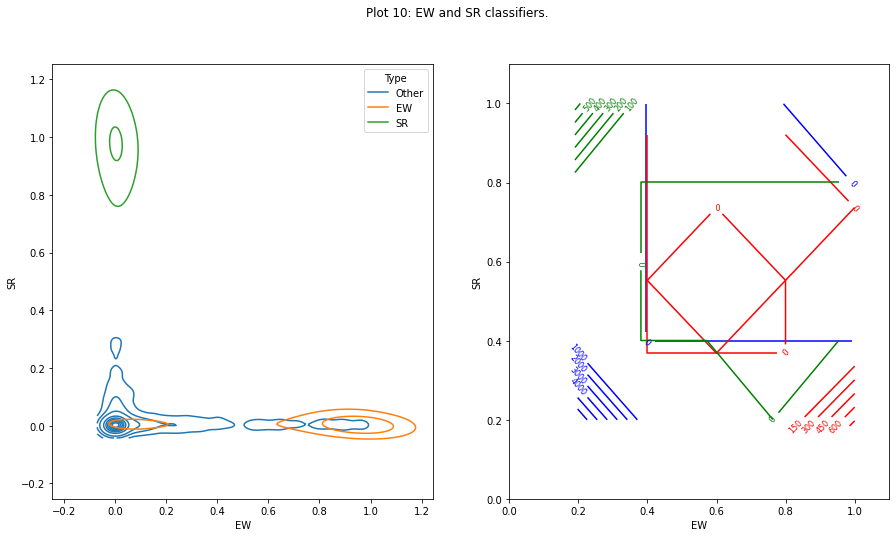

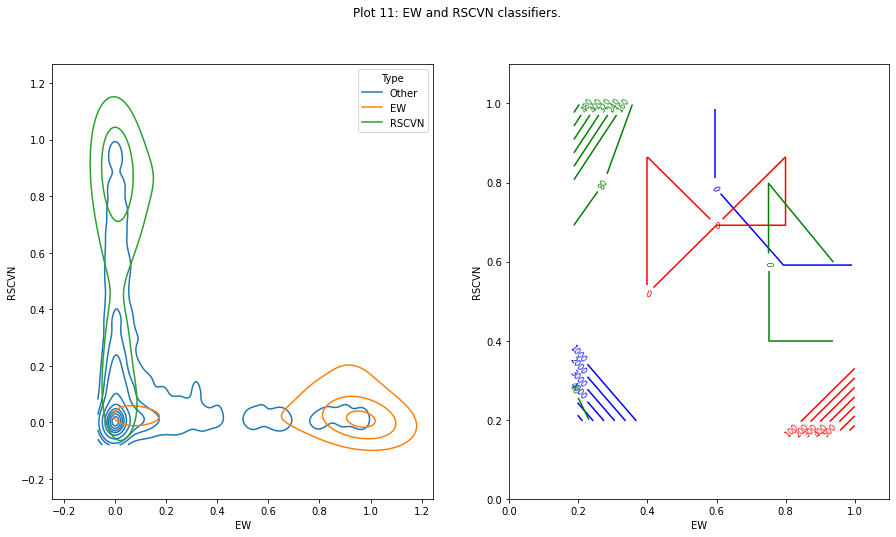

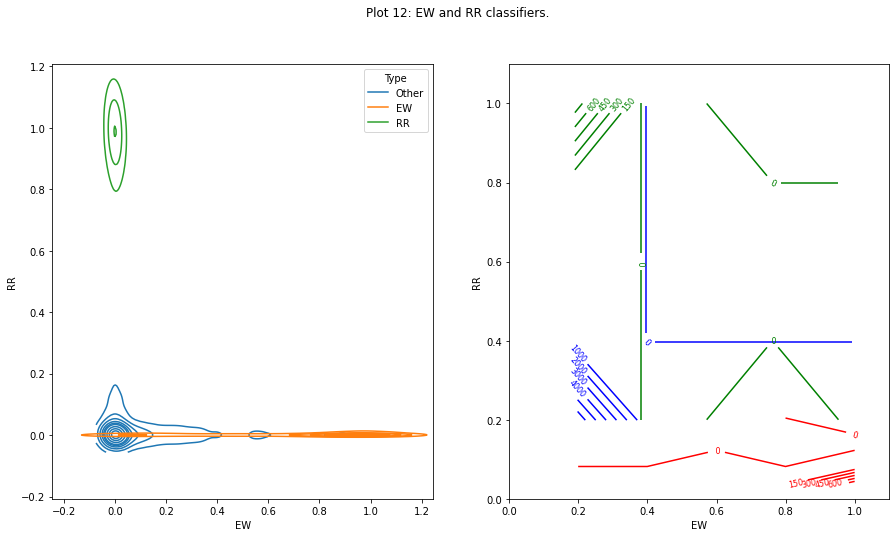

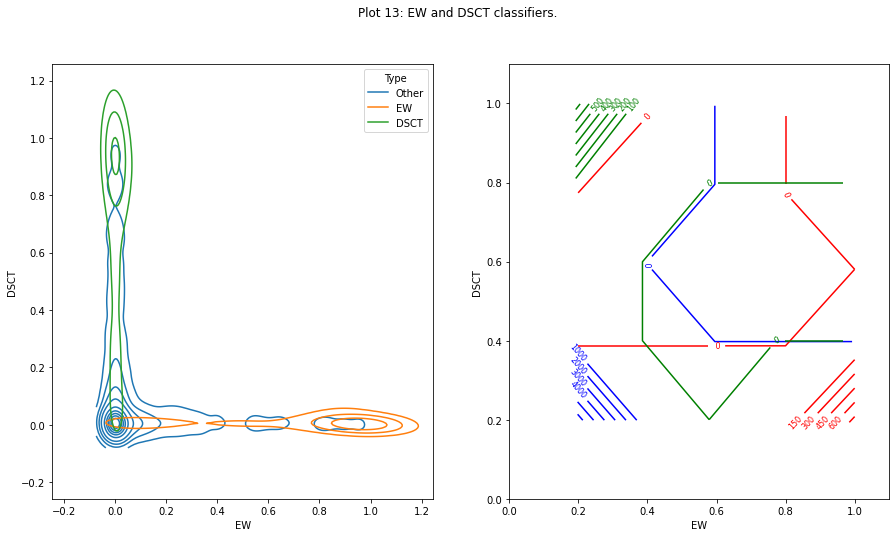

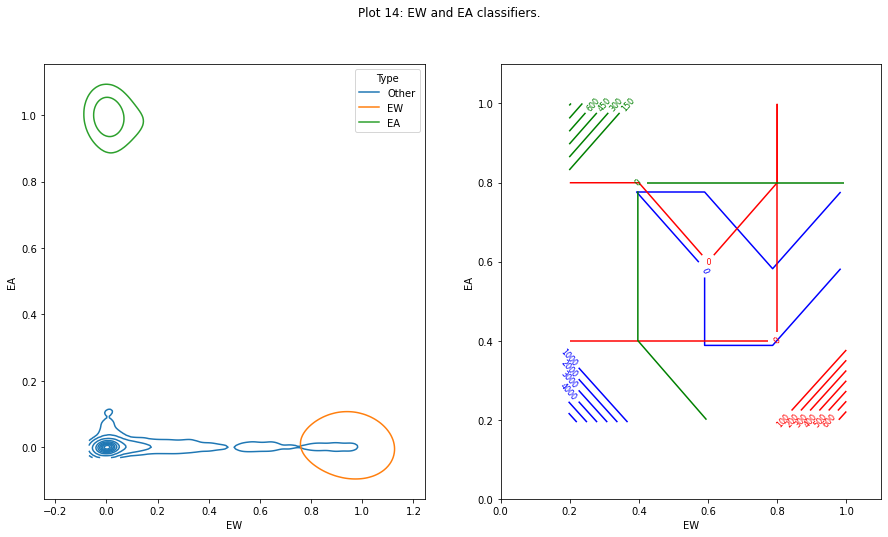

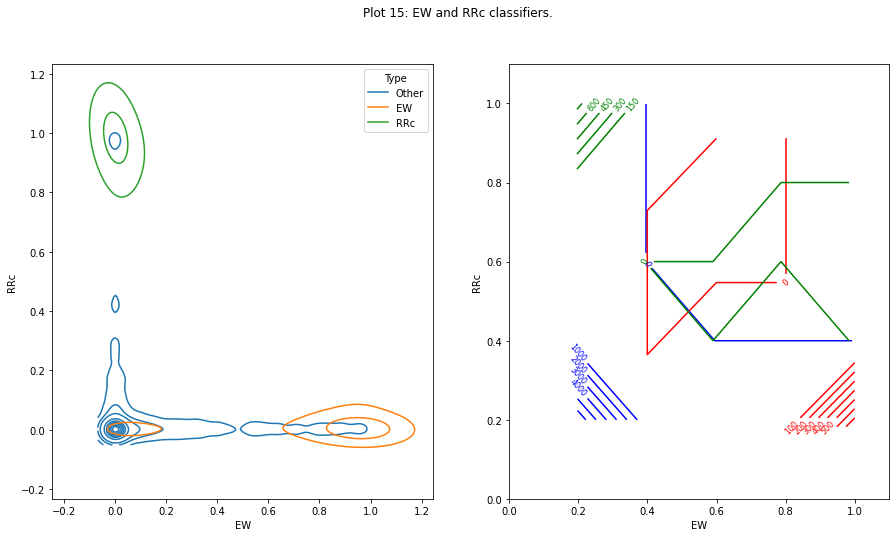

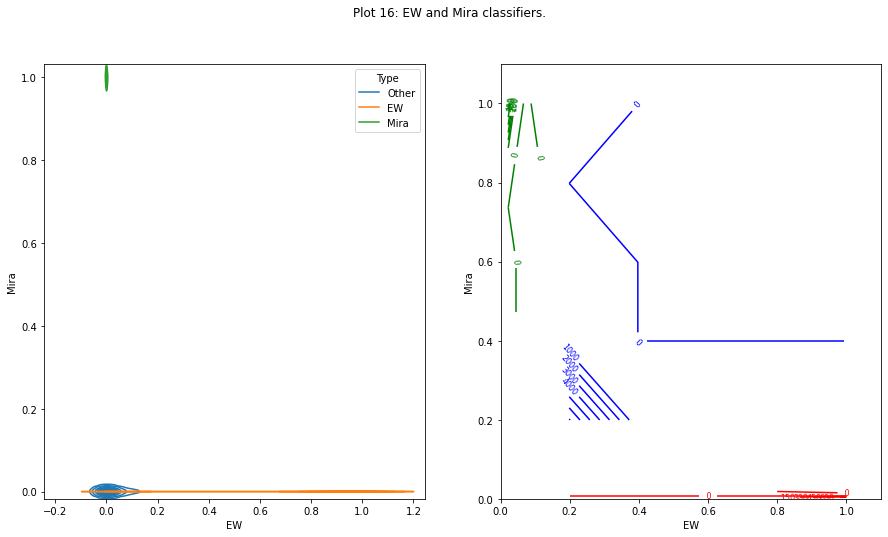

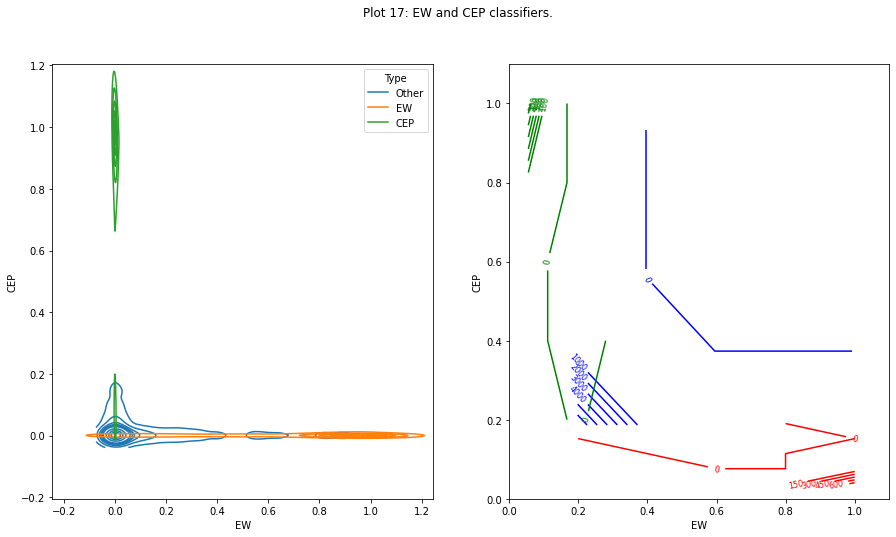

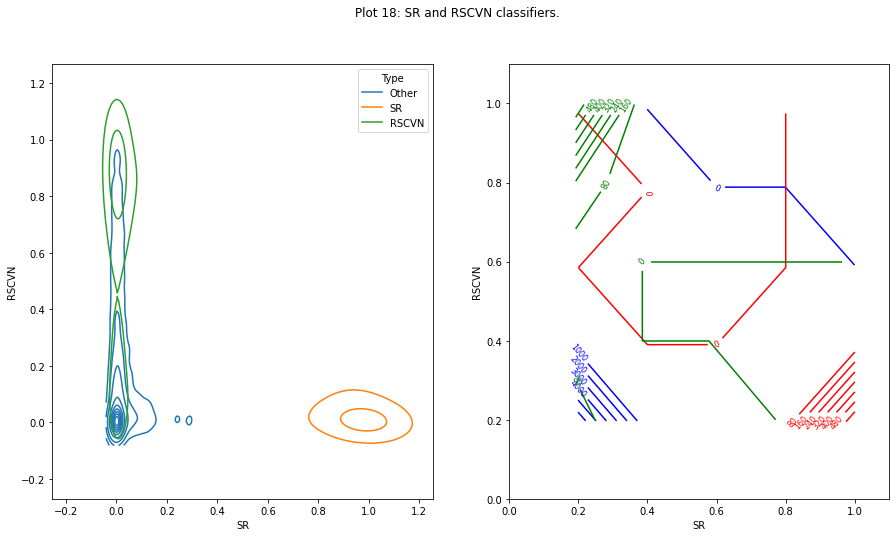

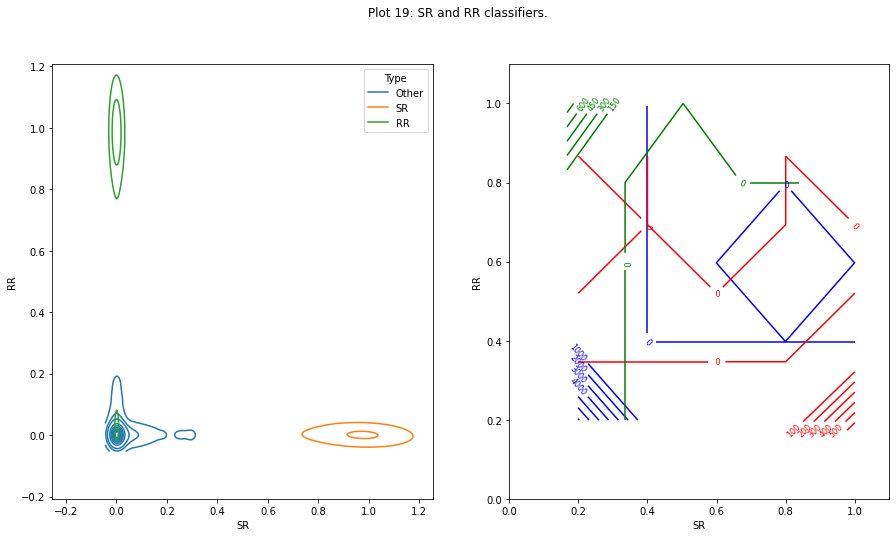

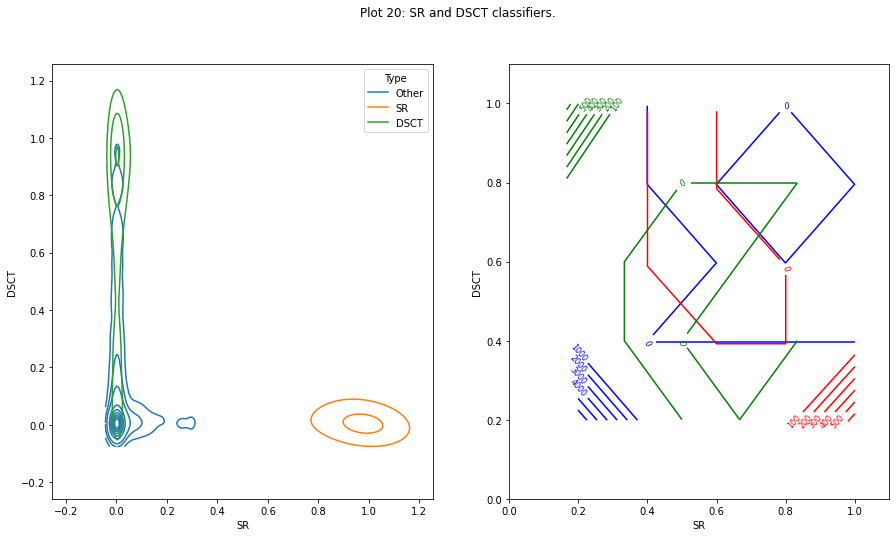

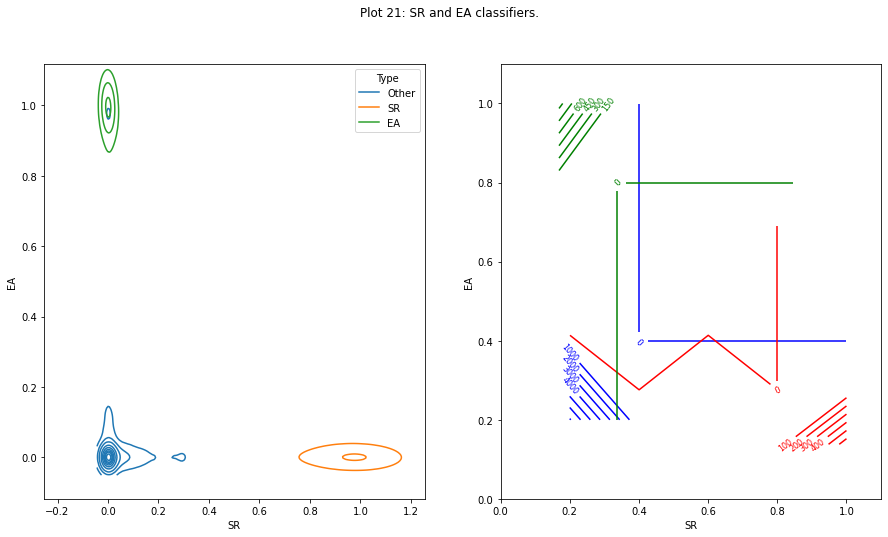

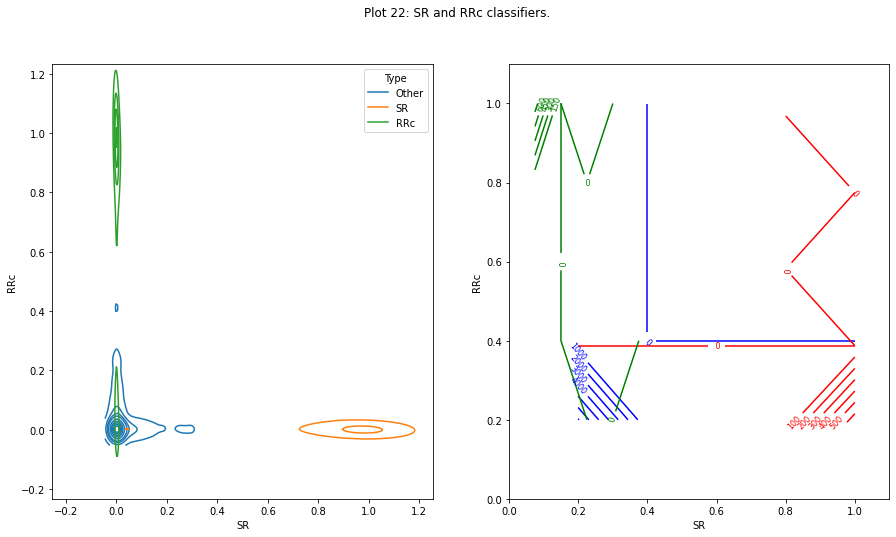

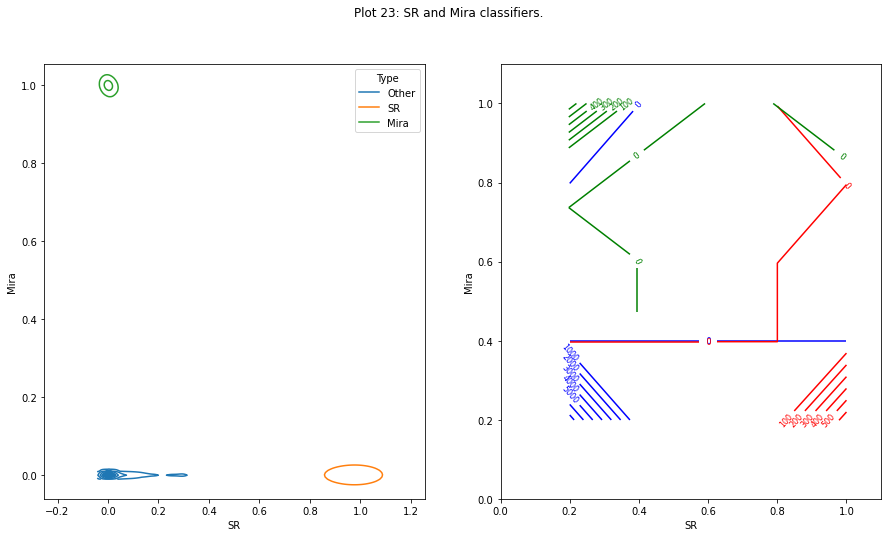

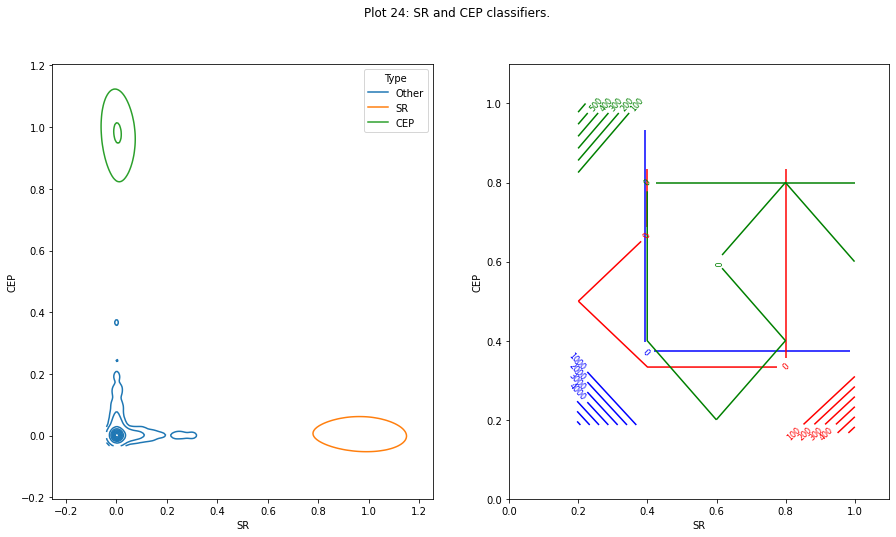

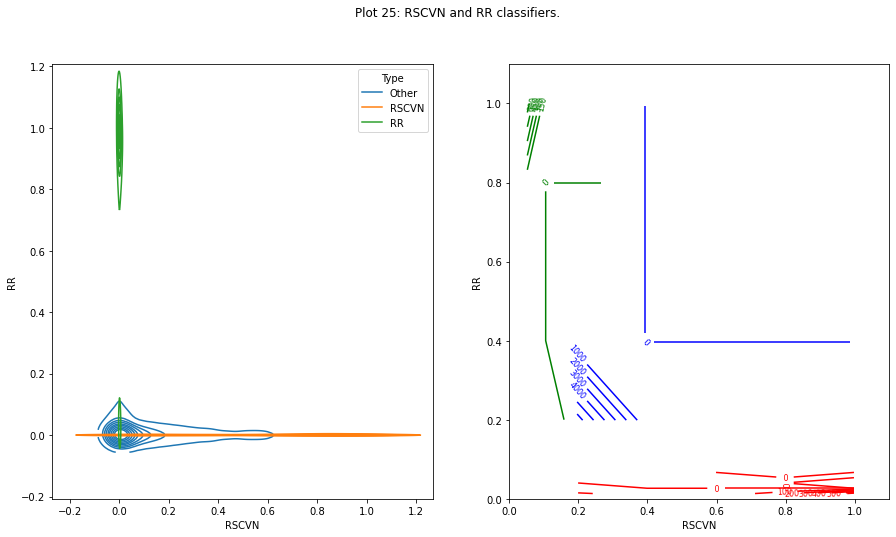

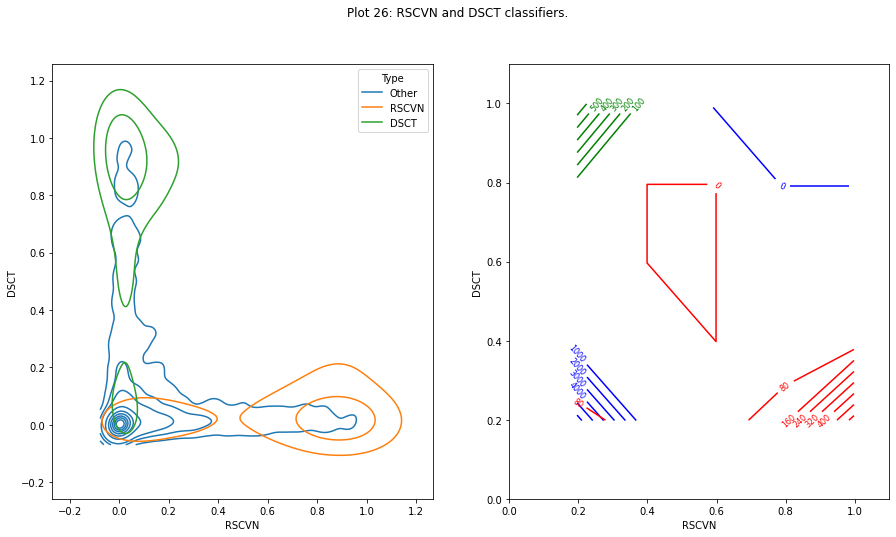

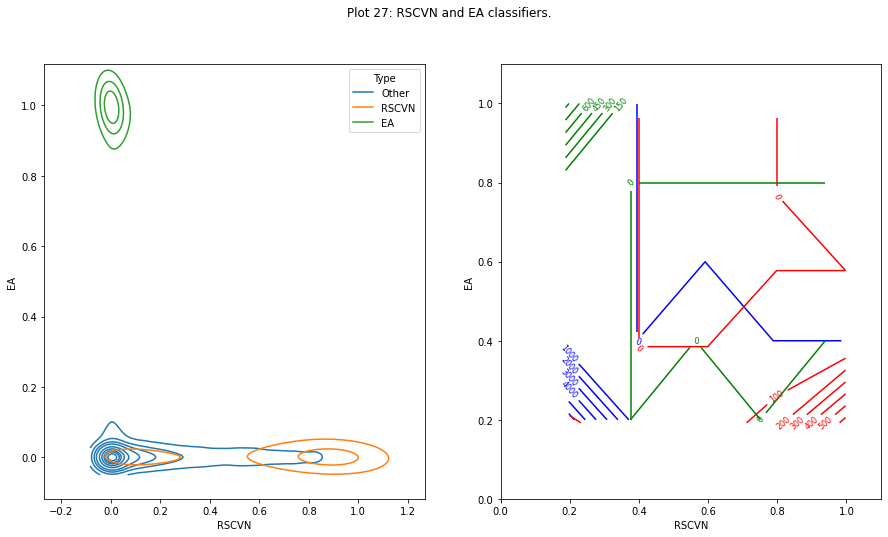

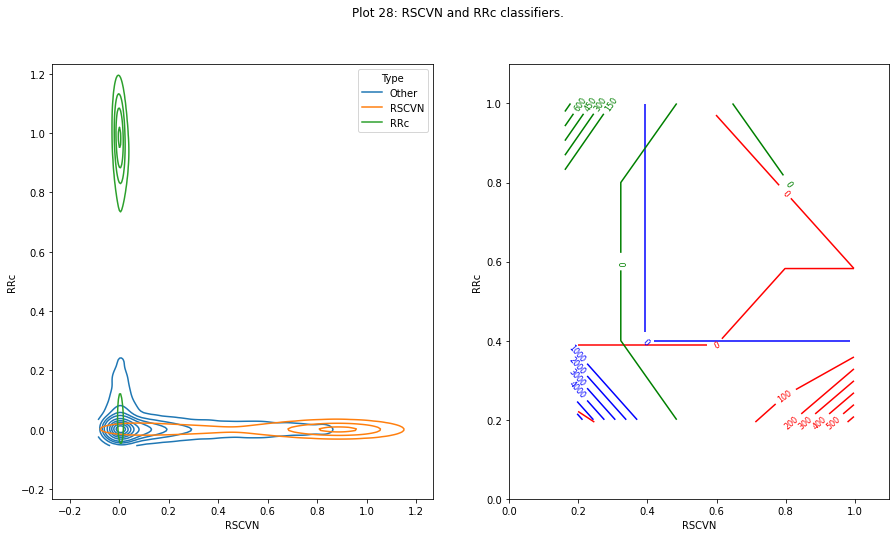

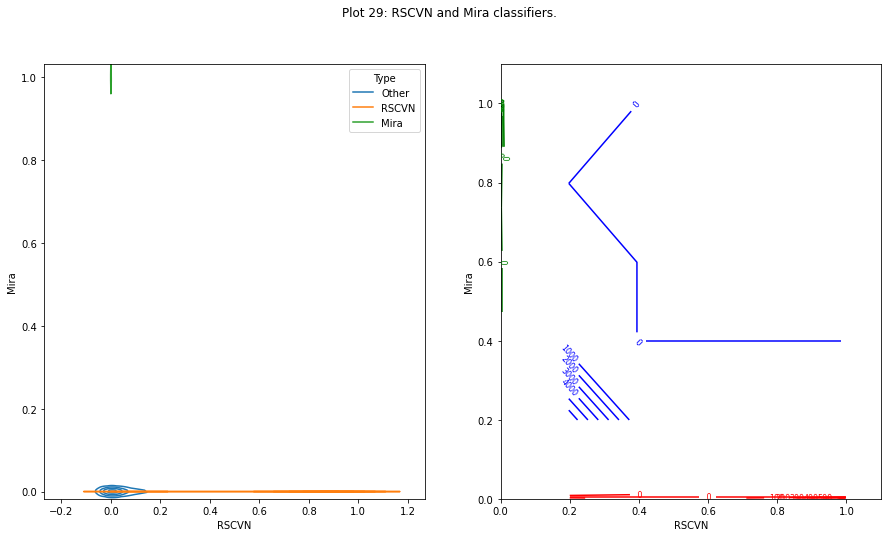

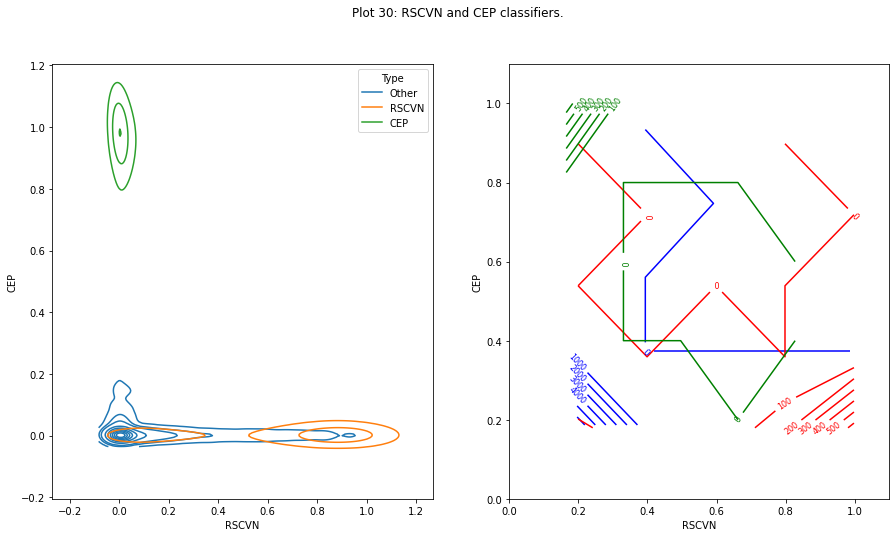

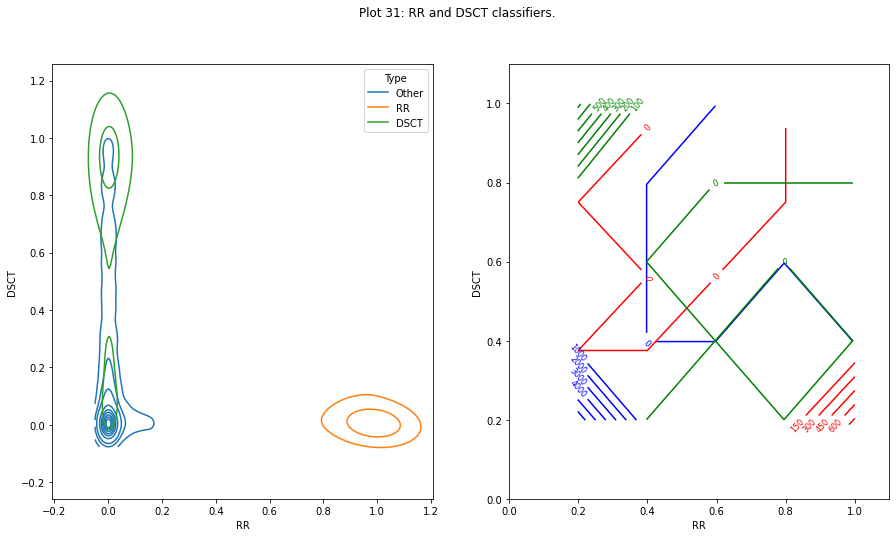

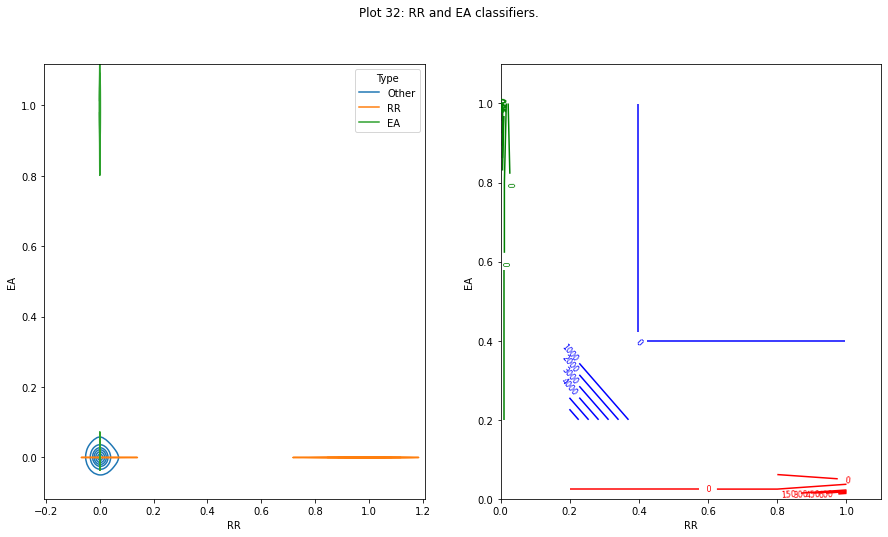

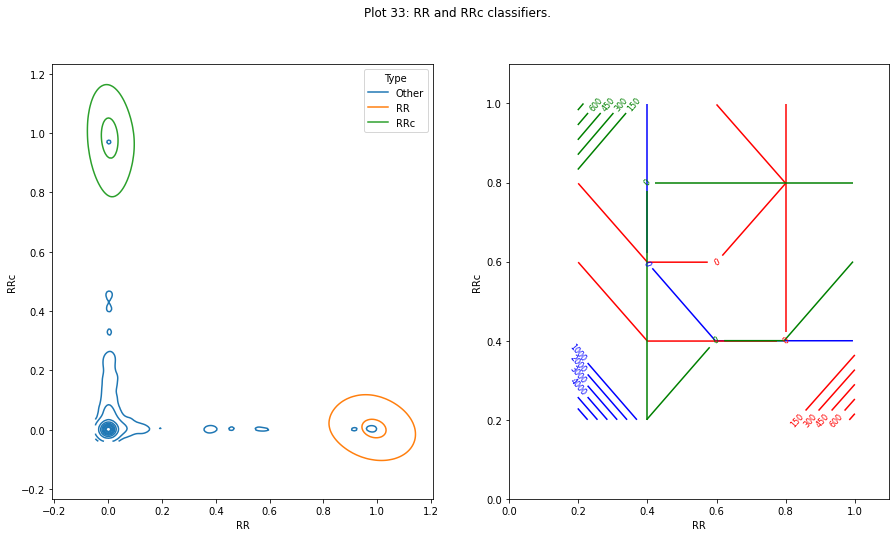

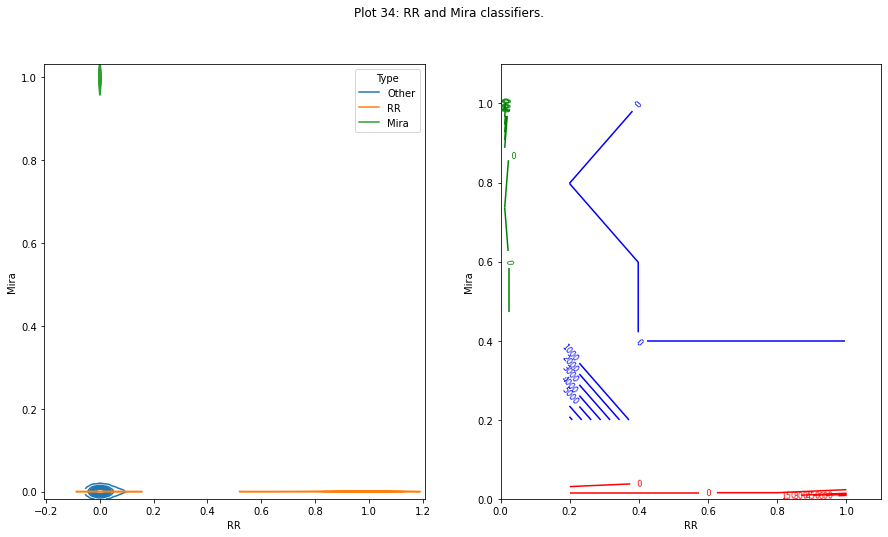

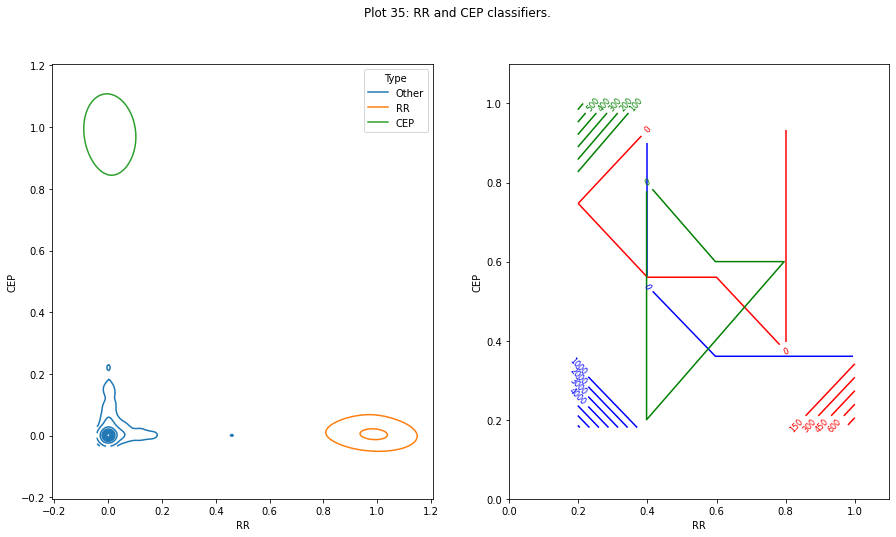

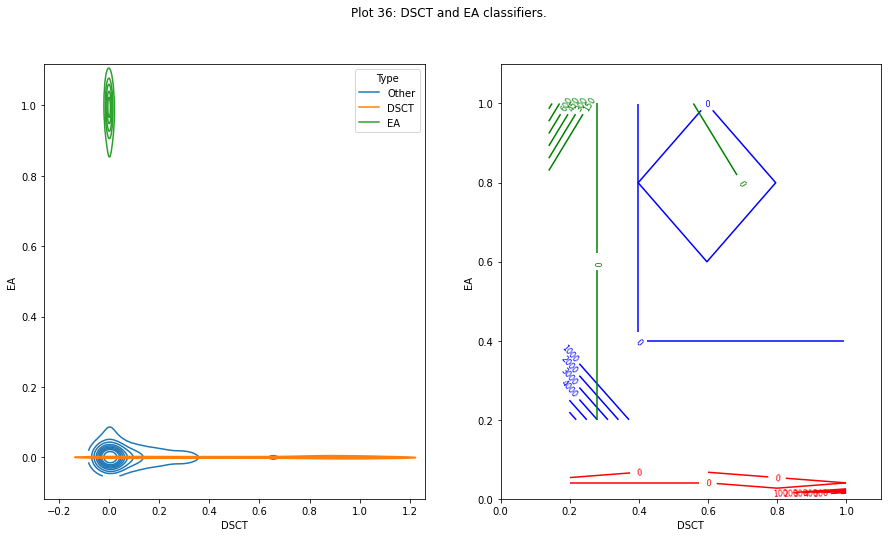

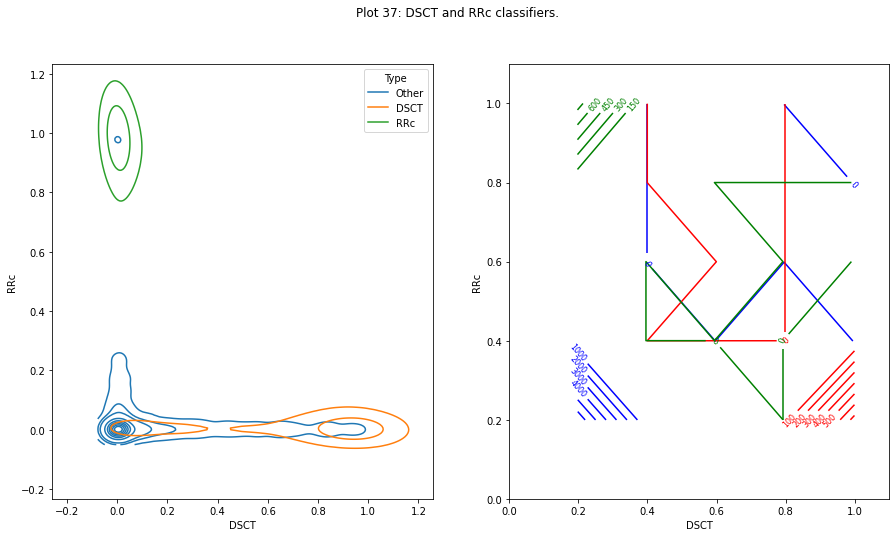

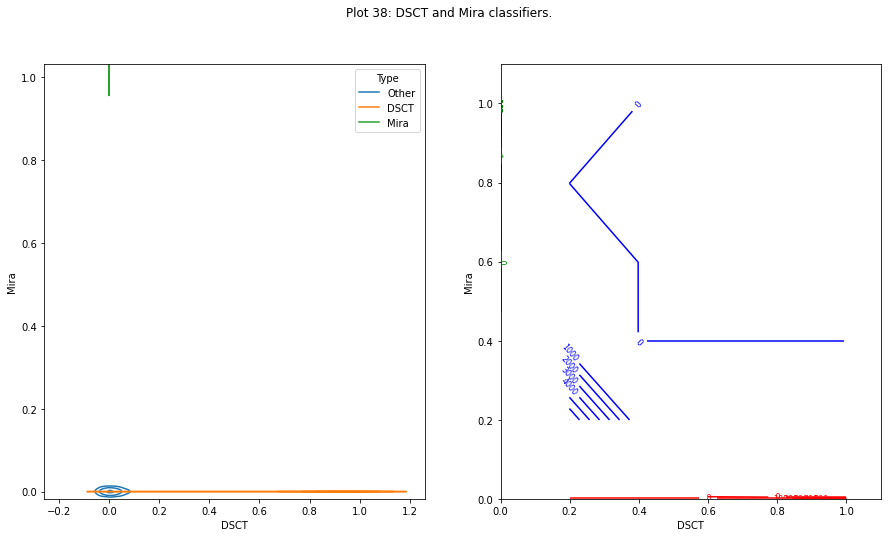

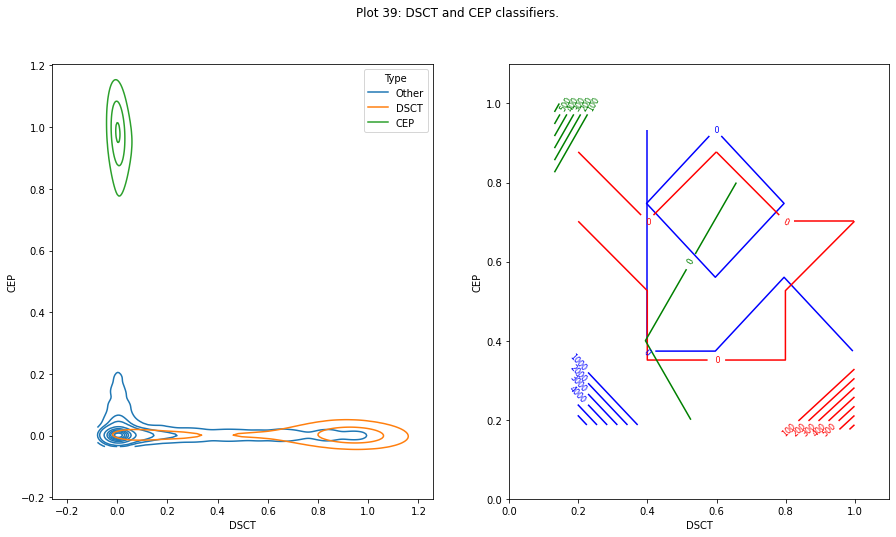

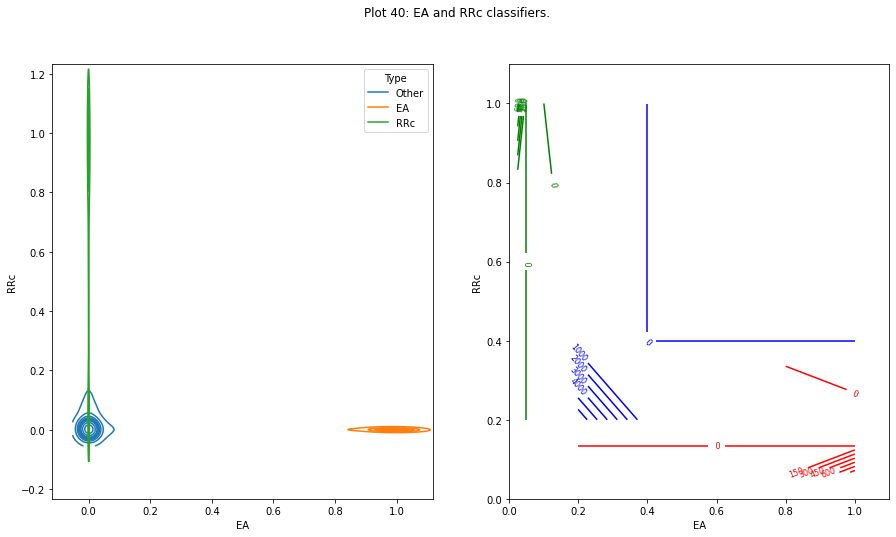

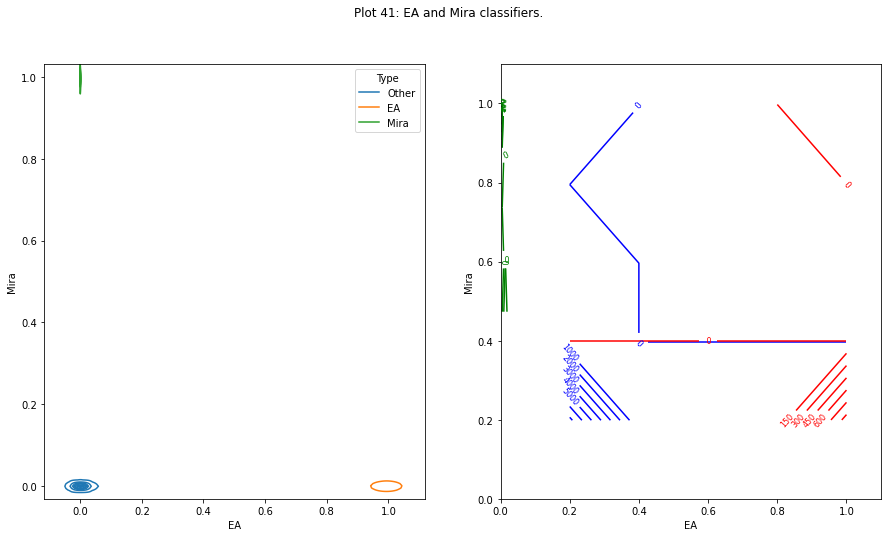

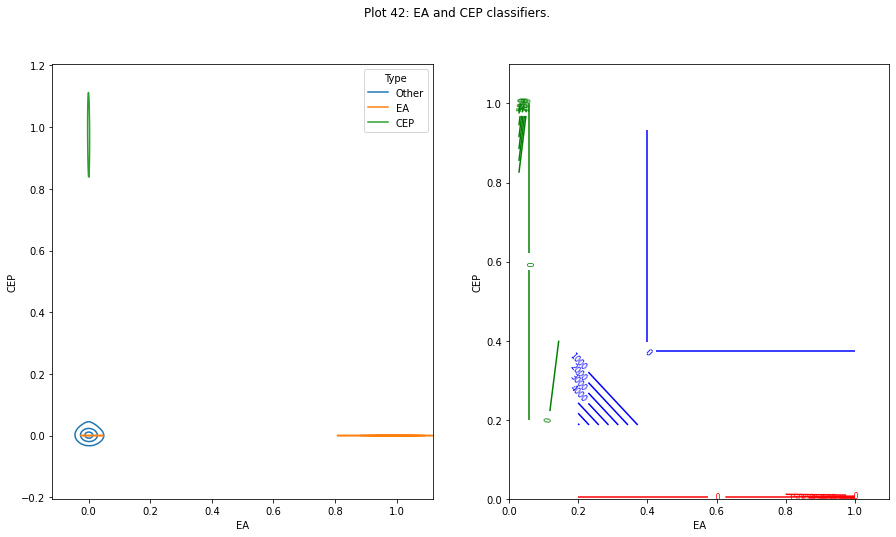

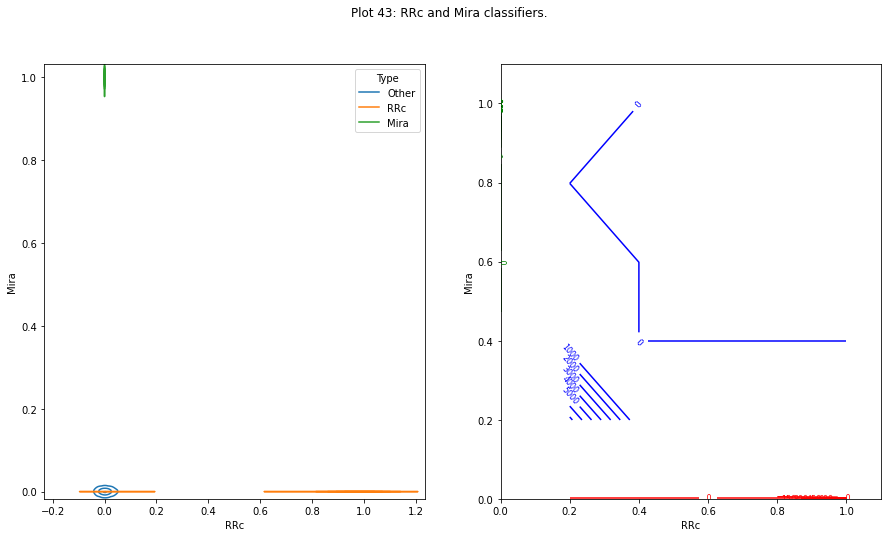

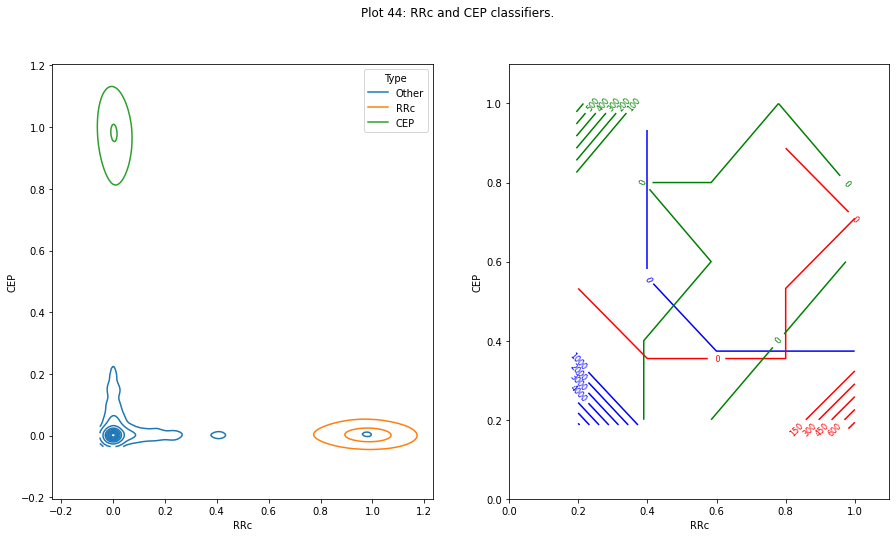

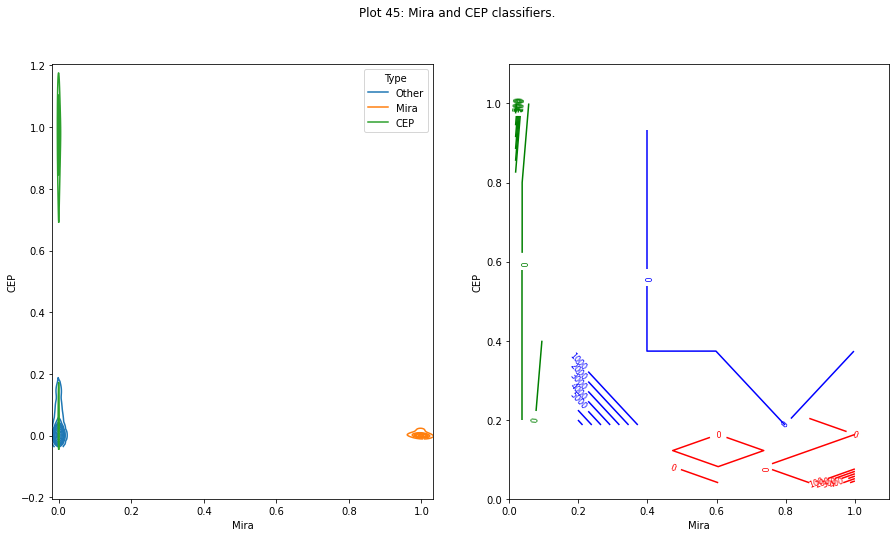

In [22]:
# plot the probabilities from 2 classifiers at a time using kernel density function and matplotlib contours

n = len(label)
j = 0
for i in range(0,n):
    for k in range(i+1,n):
        j = j+1
        variable_type1 = label[i]
        variable_type2 = label[k]
        df_prob = pd.DataFrame(columns=[variable_type1, variable_type2, 'Type'])
        prob1 = all_probs[variable_type1][:,0]
        prob2 = all_probs[variable_type2][:,0]
        df_prob[variable_type1] = prob1
        df_prob[variable_type2] = prob2
        ind1 = df.index[df['Type']==variable_type1].values
        ind2 = df.index[df['Type']==variable_type2].values
        ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        
        
        df_prob.loc[ind1,'Type'] = variable_type1
        df_prob.loc[ind2,'Type'] = variable_type2
        df_prob.loc[ind3,'Type'] = 'Other' 
        
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,8))
        sns.kdeplot(data = df_prob,x=variable_type1,y=variable_type2, ax=ax1, hue='Type')
        
        x = prob1[ind3]
        indx = x<=0.3
        xp = x[indx==True]
        
        y = prob2[ind3]
        indy = y<=0.3
        yp = x[indx==True]
        
        H, xedges, yedges = np.histogram2d(prob1[ind3],prob2[ind3], bins=(5,5))
#         H, xedges, yedges = np.histogram2d(xp,yp, bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='blue')
        ax2.set_xlim([0,1.1])
        ax2.set_ylim([0,1.1])
        ax2.clabel(contours,fmt = '%2.1d', inline=True, fontsize=8)
        
        
        H, xedges, yedges = np.histogram2d(prob1[ind1],prob2[ind1], bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='red')
        ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
        H, xedges, yedges = np.histogram2d(prob1[ind2],prob2[ind2], bins=(5,5))
        contours=ax2.contour(xedges[1:],yedges[1:],H.T, colors='green')
        ax2.clabel(contours, fmt = '%2.1d', inline=True, fontsize=8)
        
        plt.xlabel(variable_type1)
        plt.ylabel(variable_type2)
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        fig.suptitle(title_string)

        plt.show()
        del ind1, ind2, ind3, df_prob, x, xp, indx, y, yp, indy

        

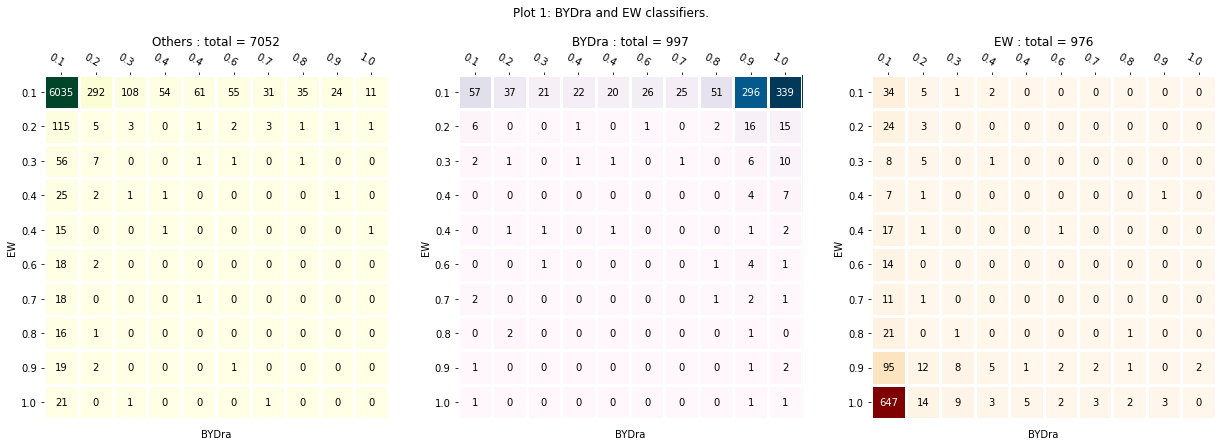

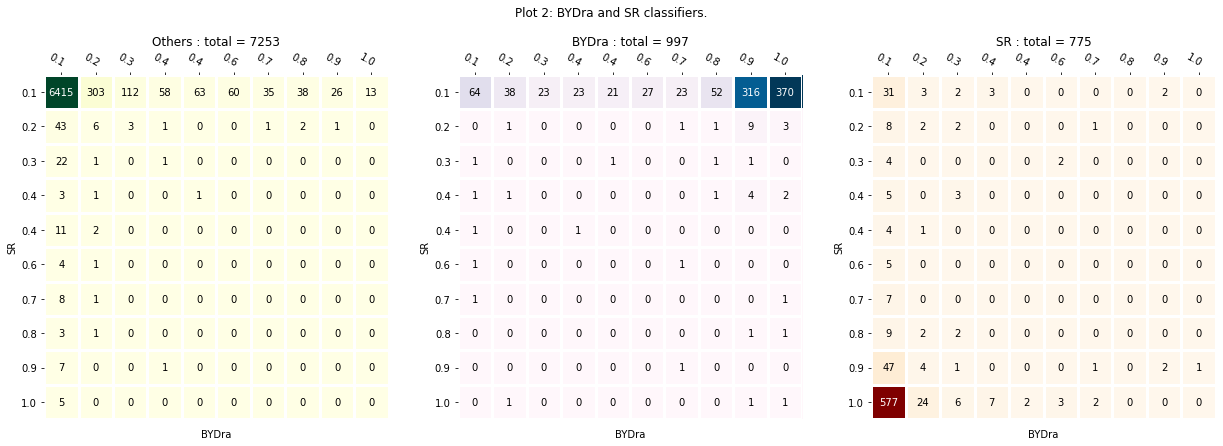

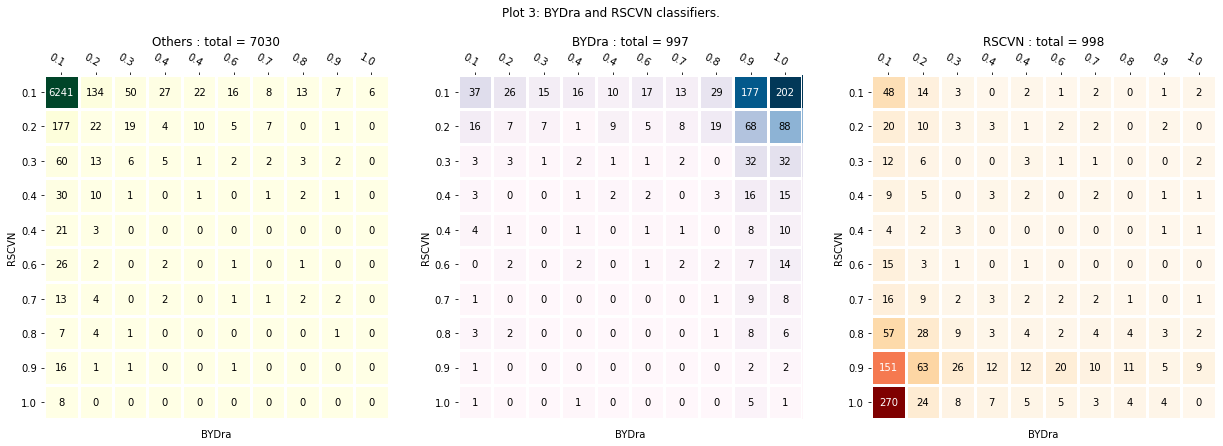

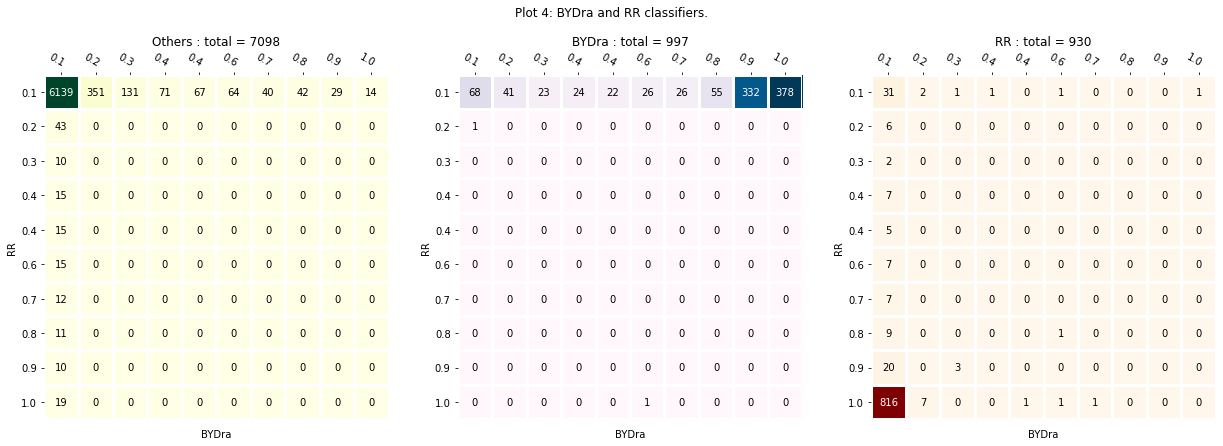

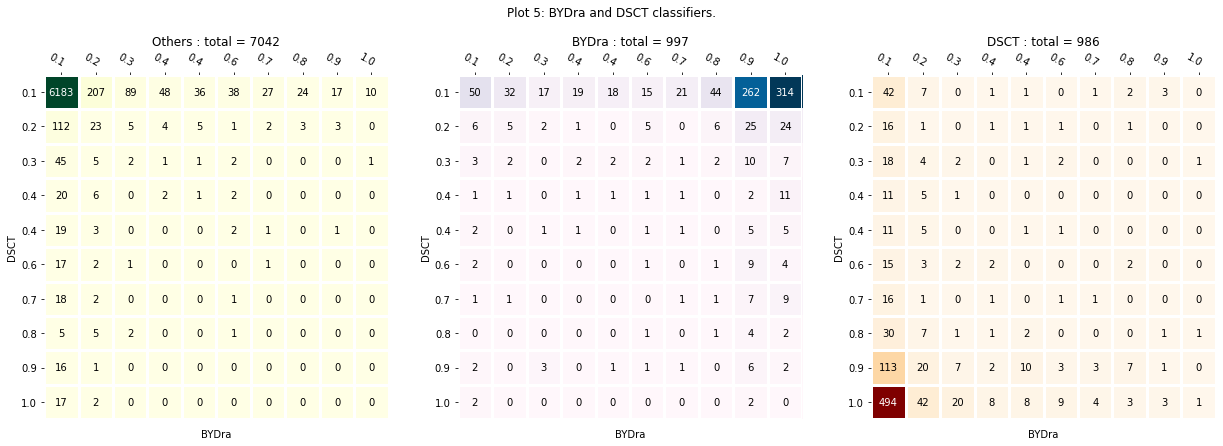

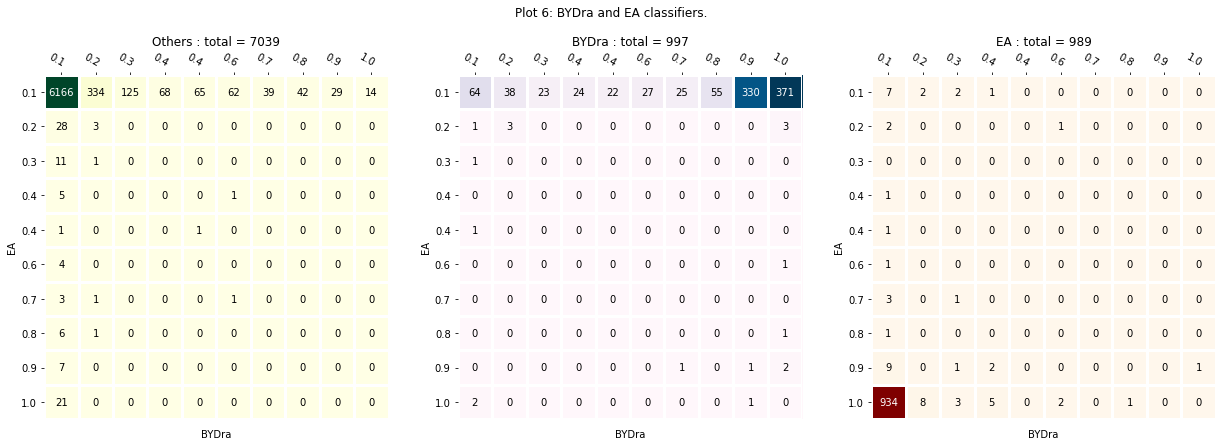

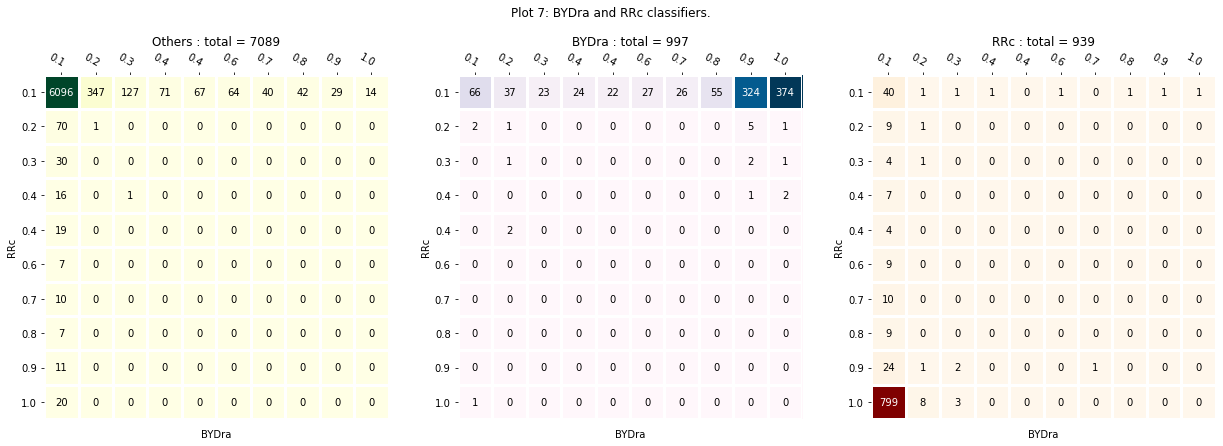

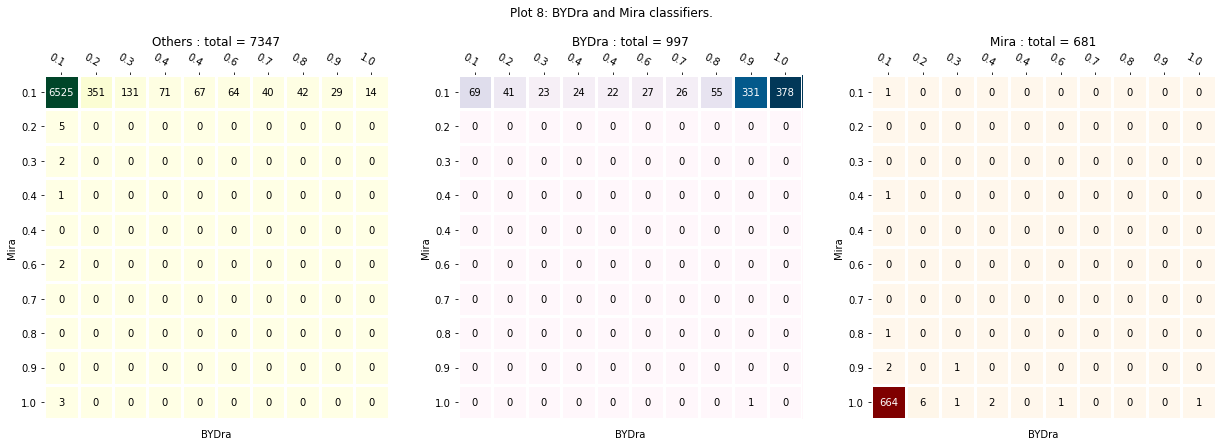

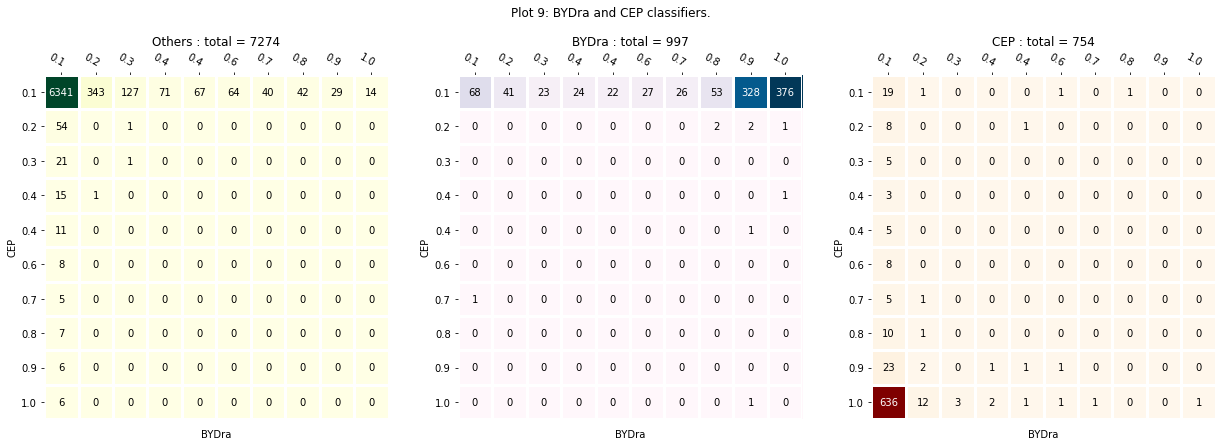

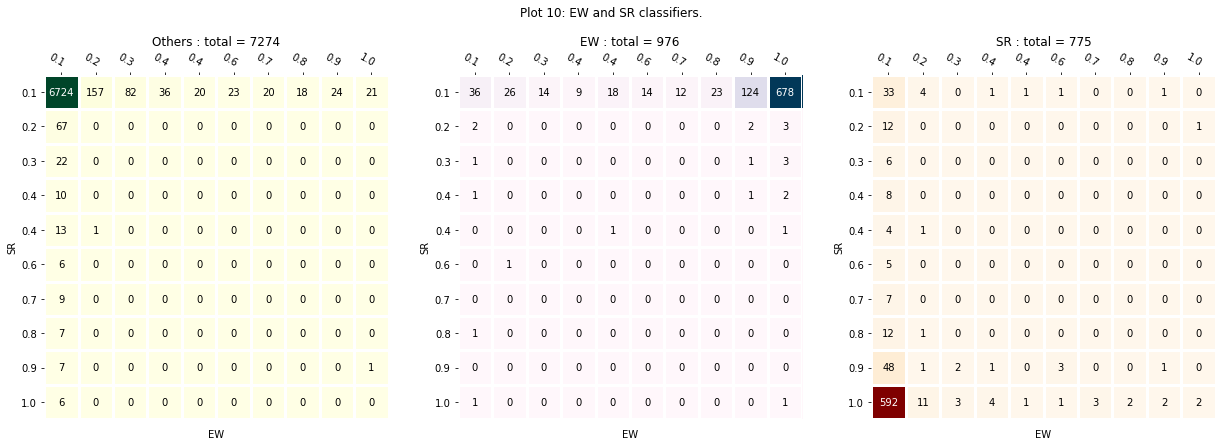

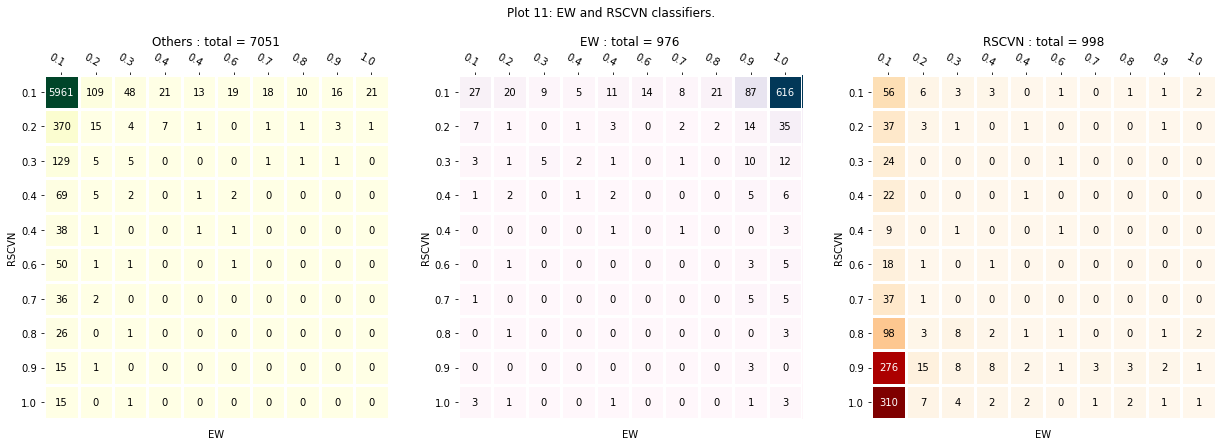

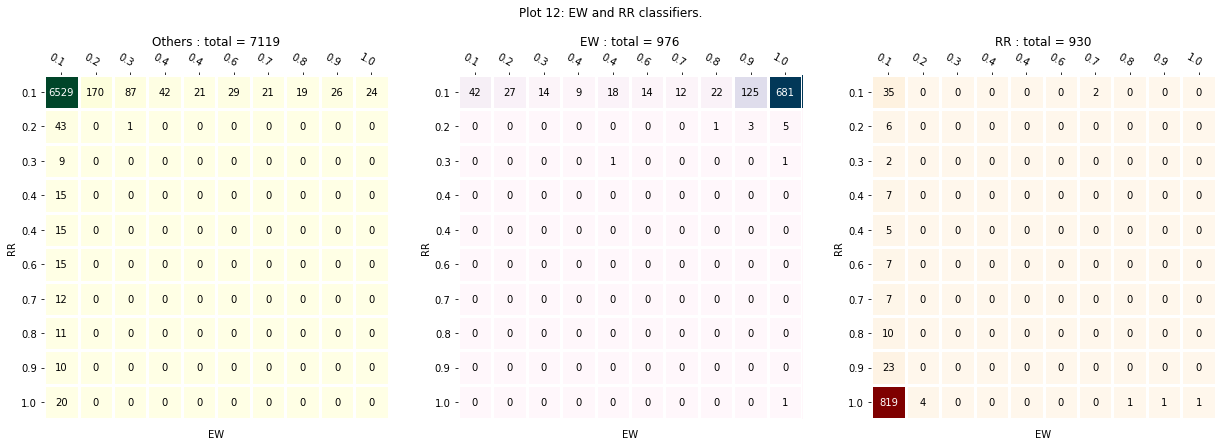

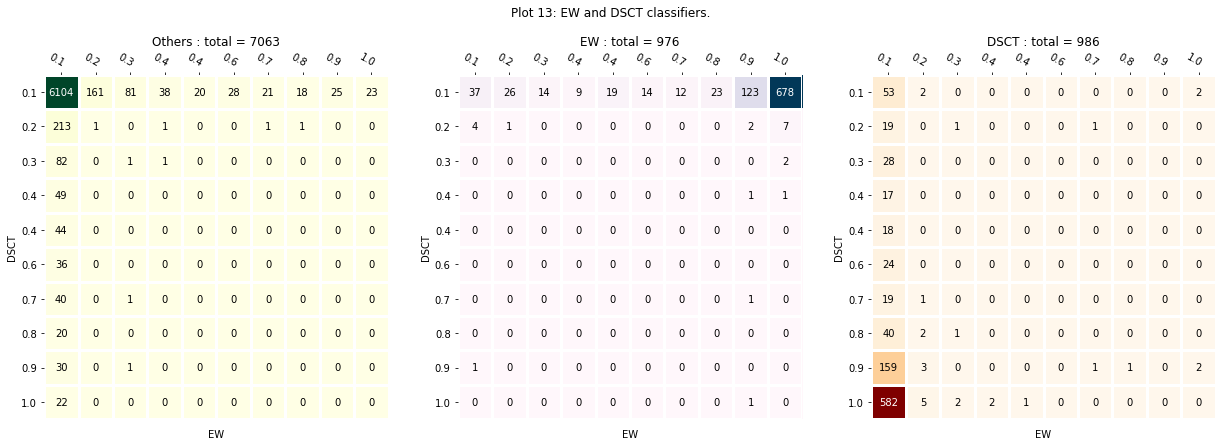

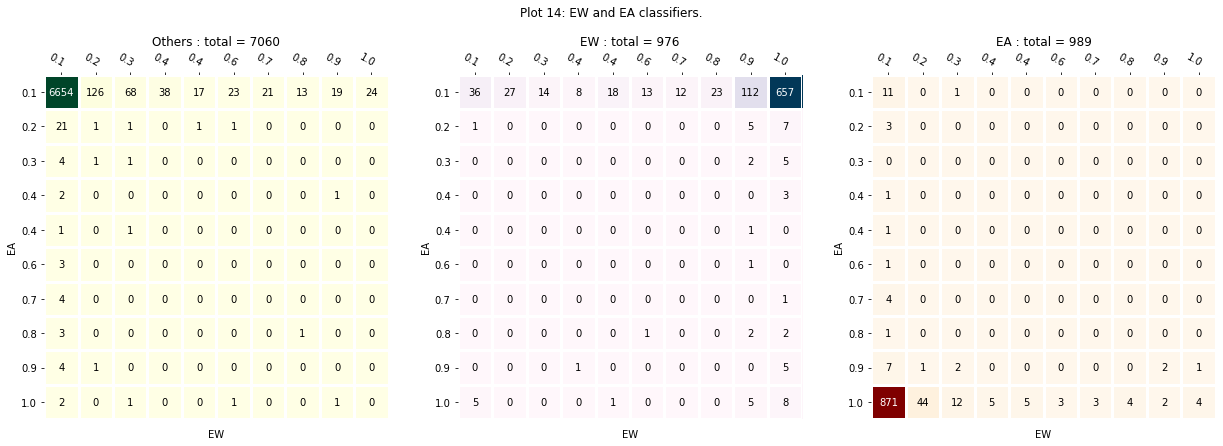

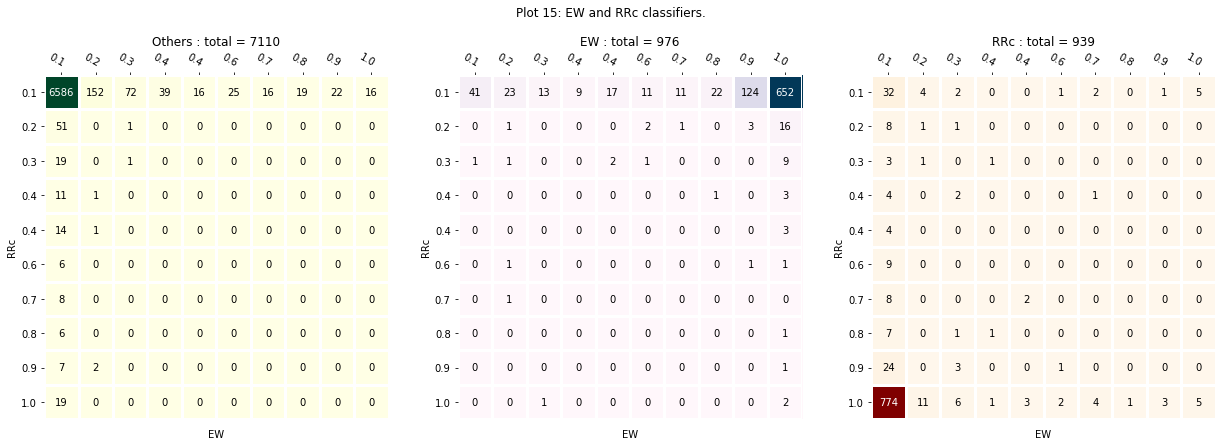

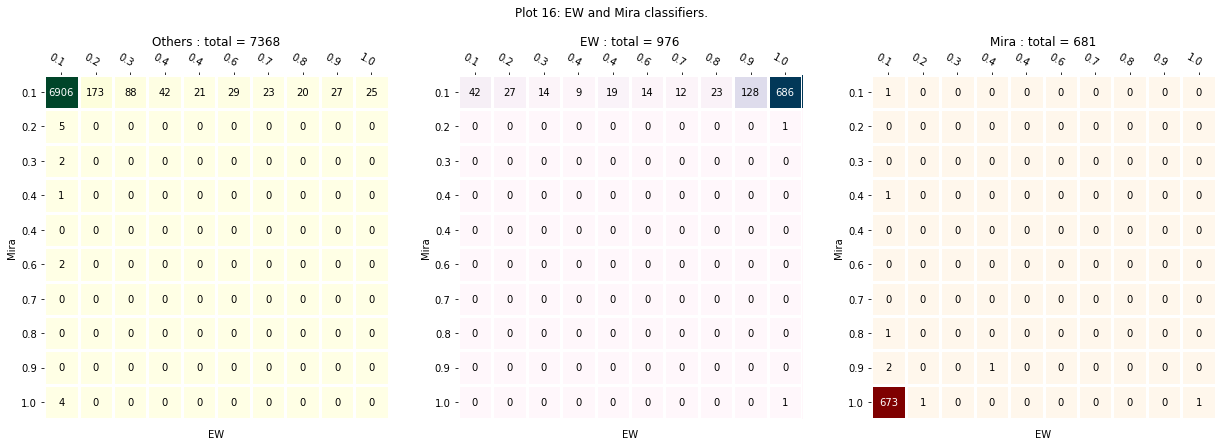

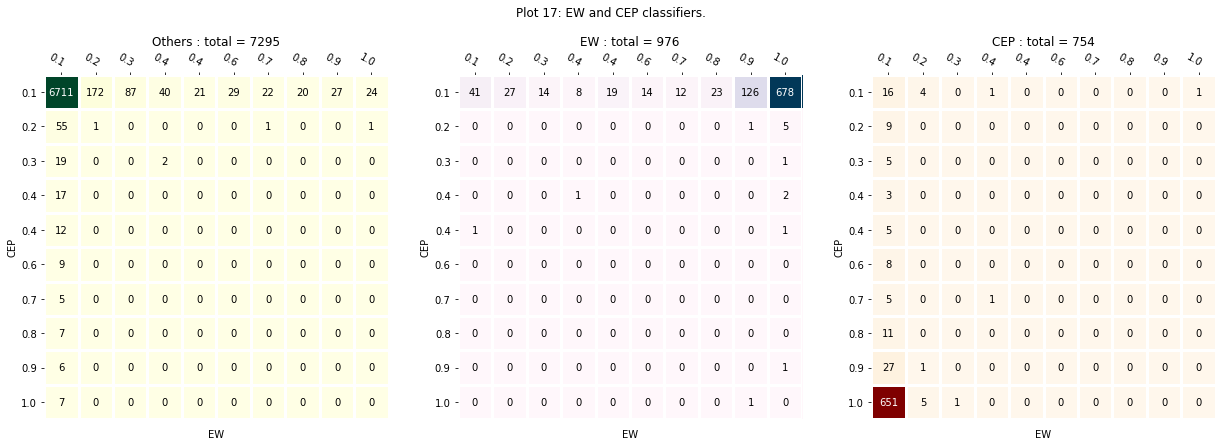

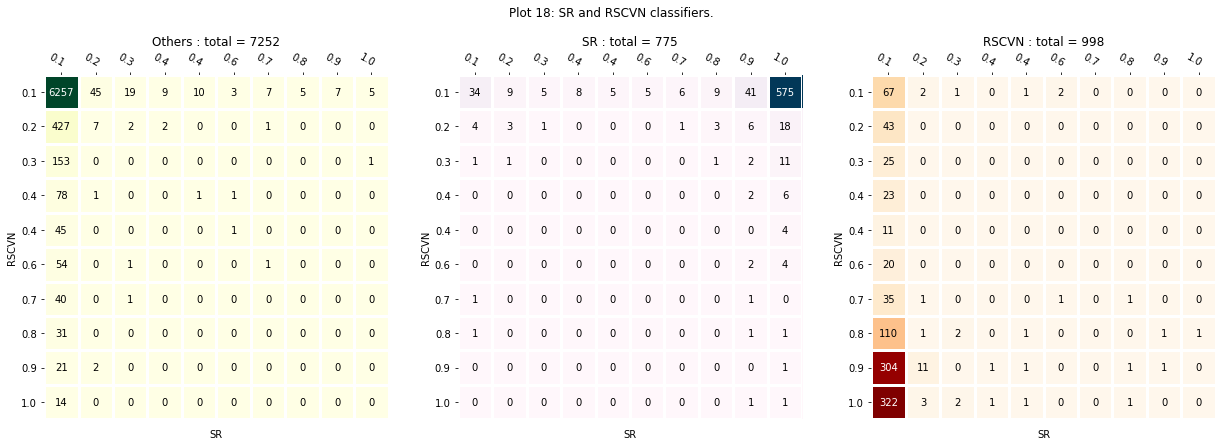

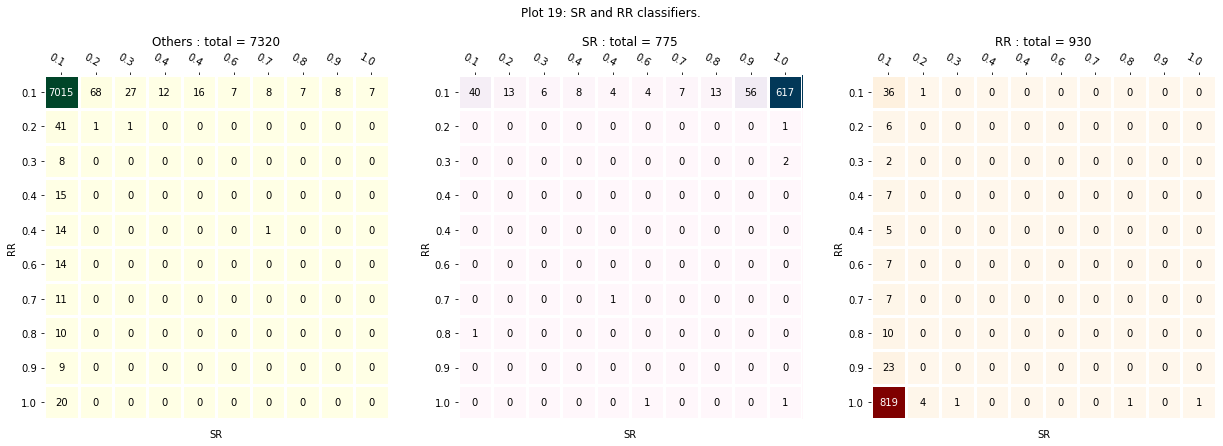

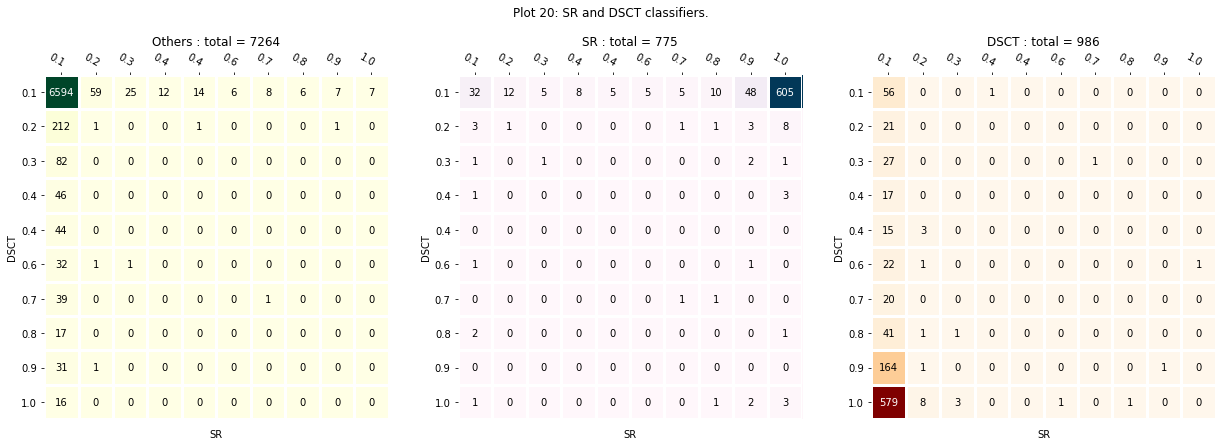

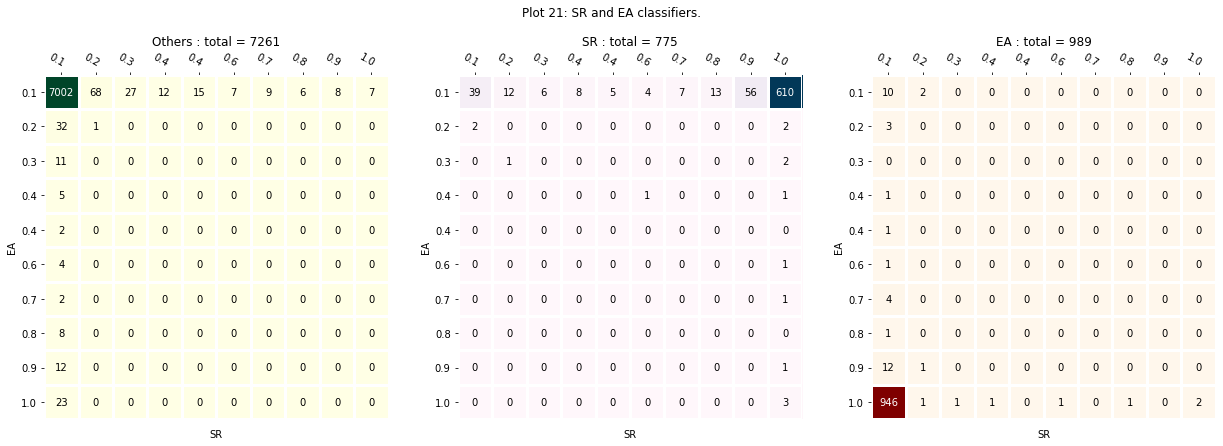

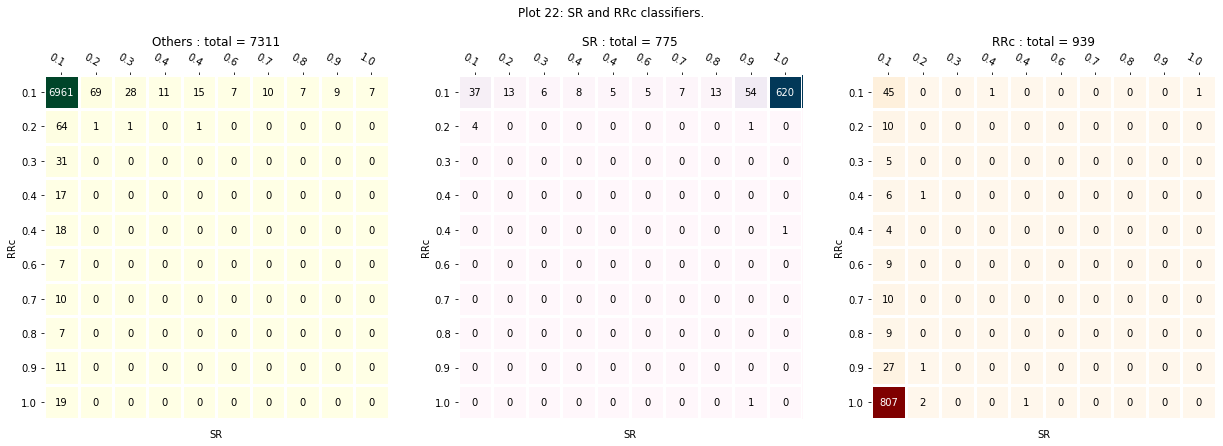

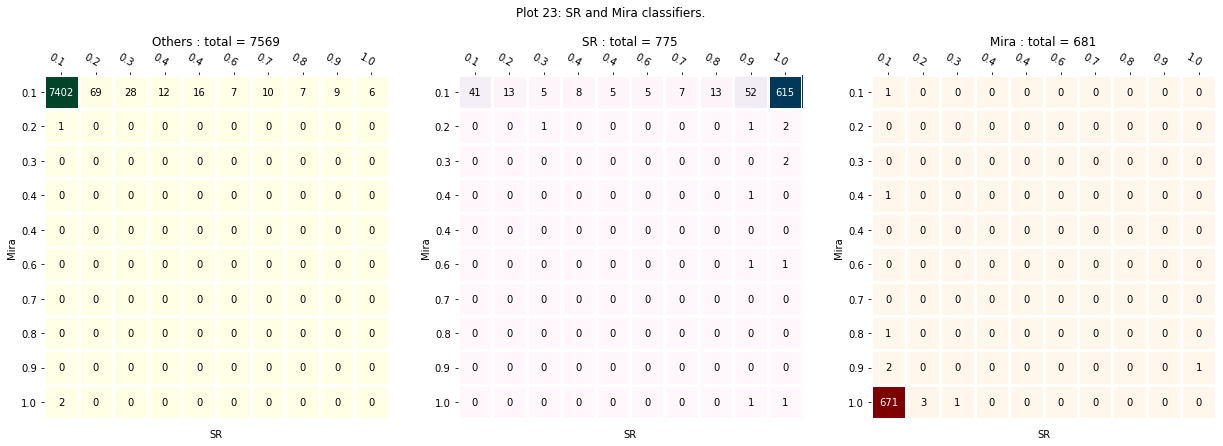

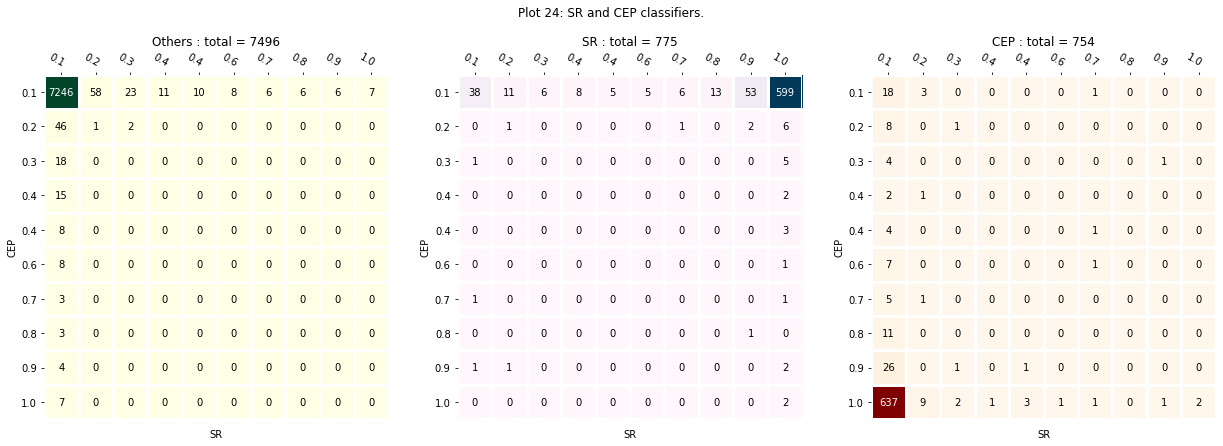

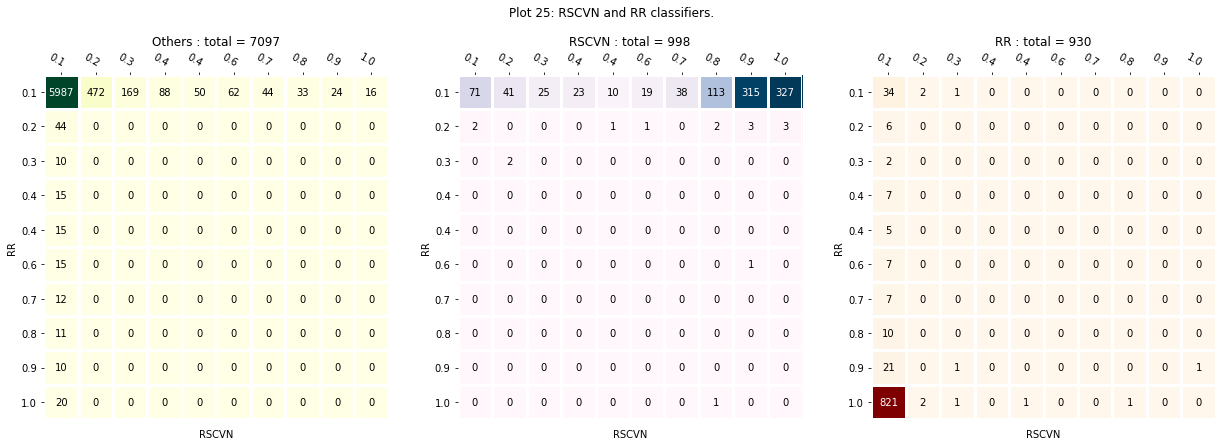

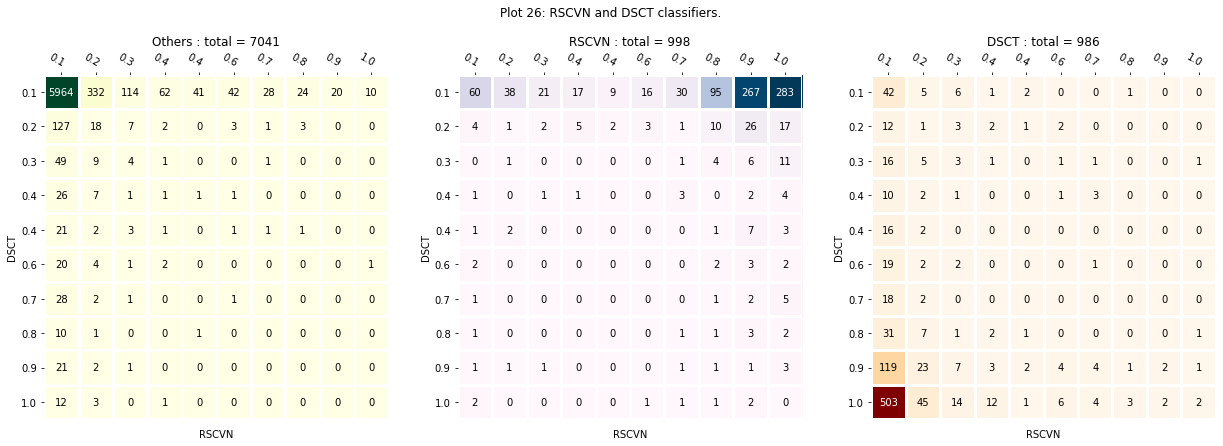

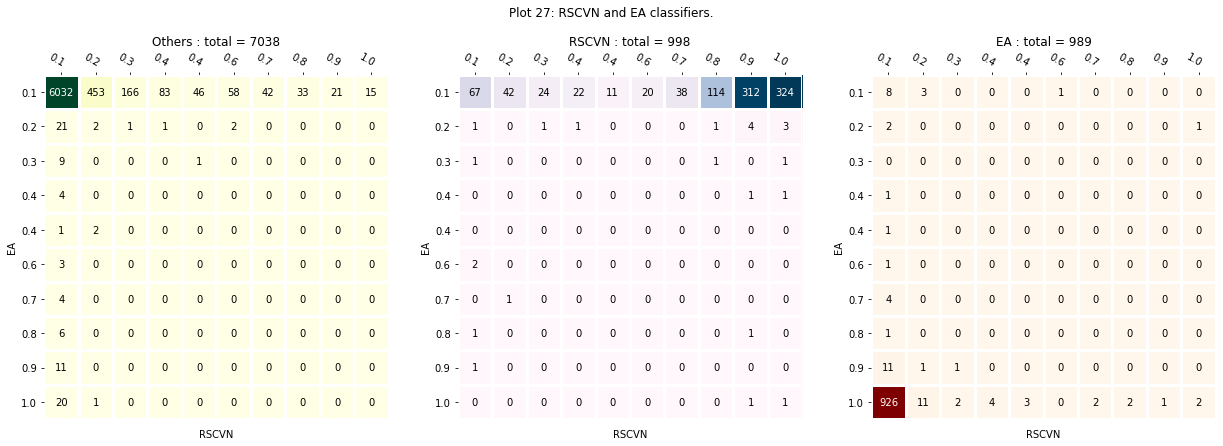

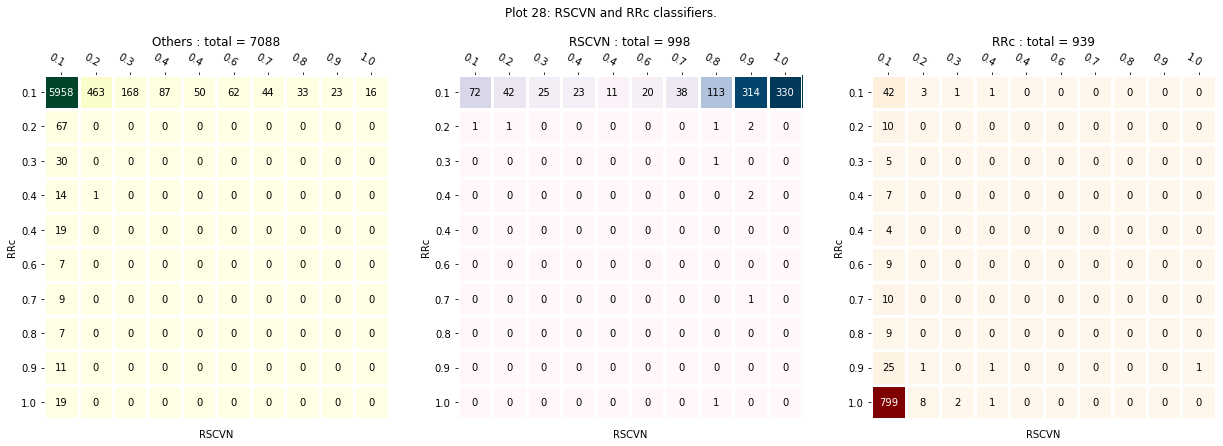

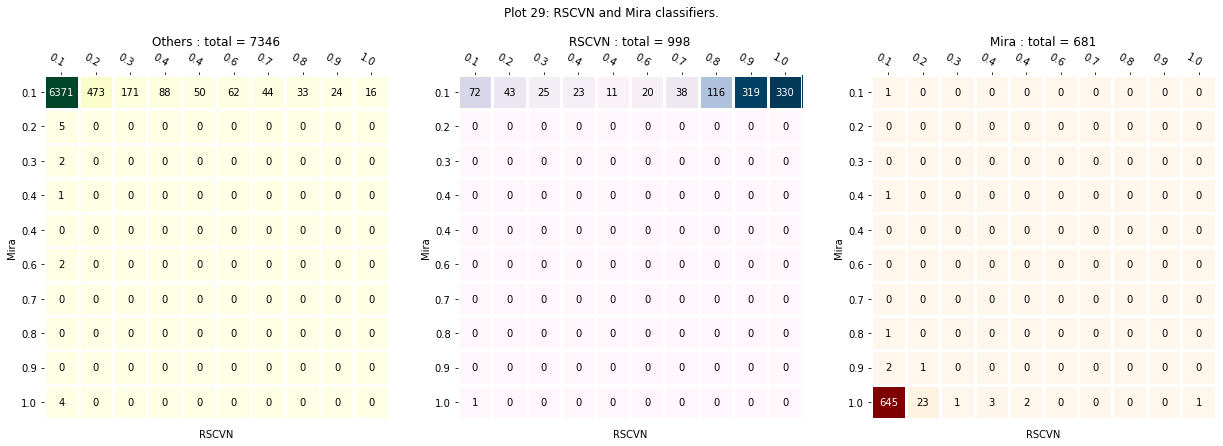

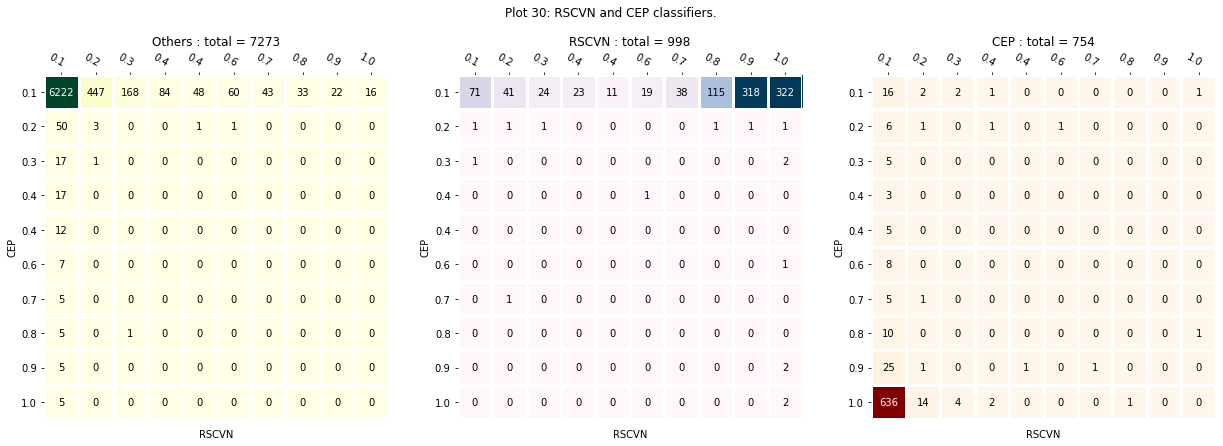

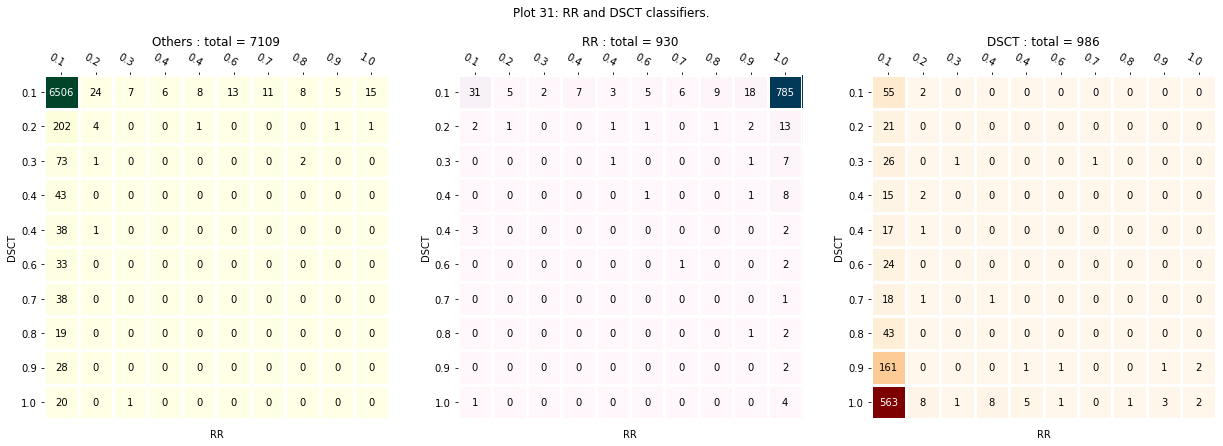

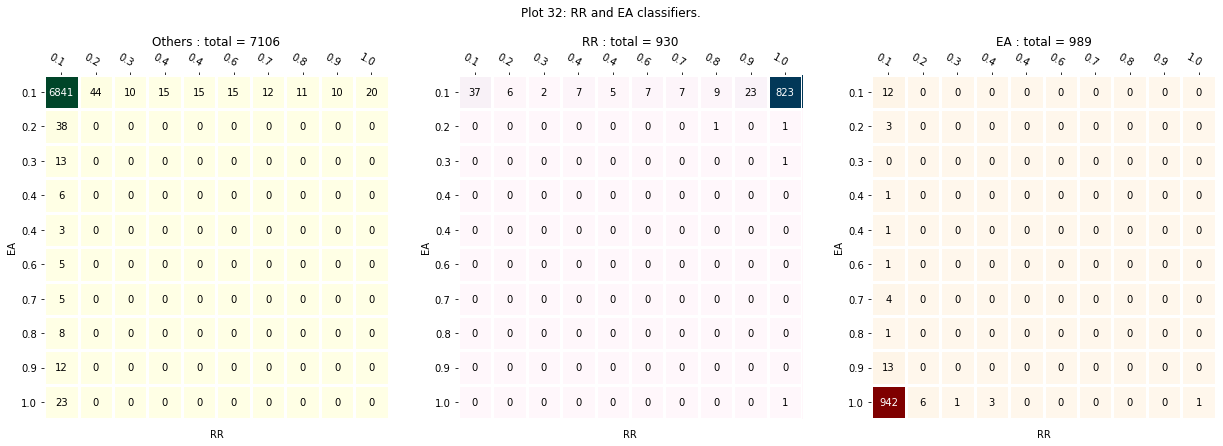

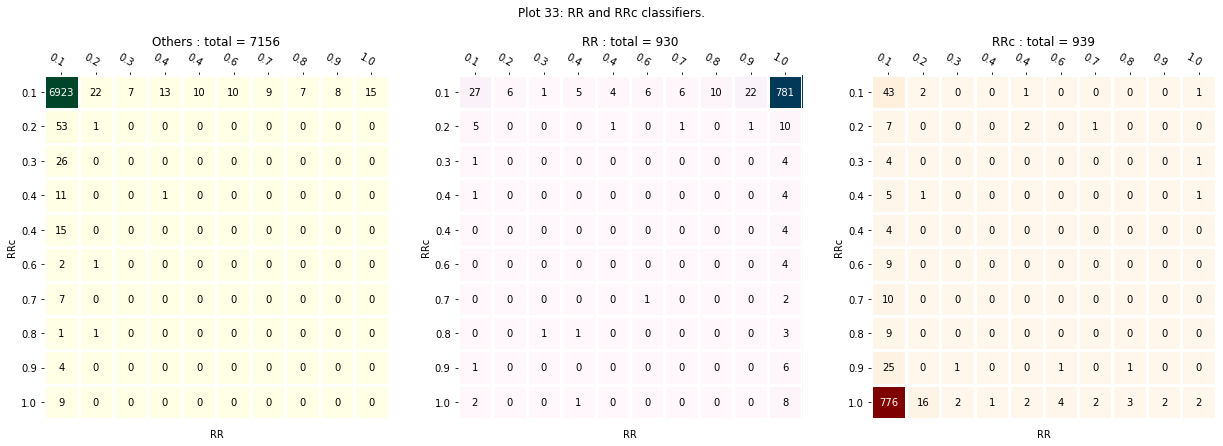

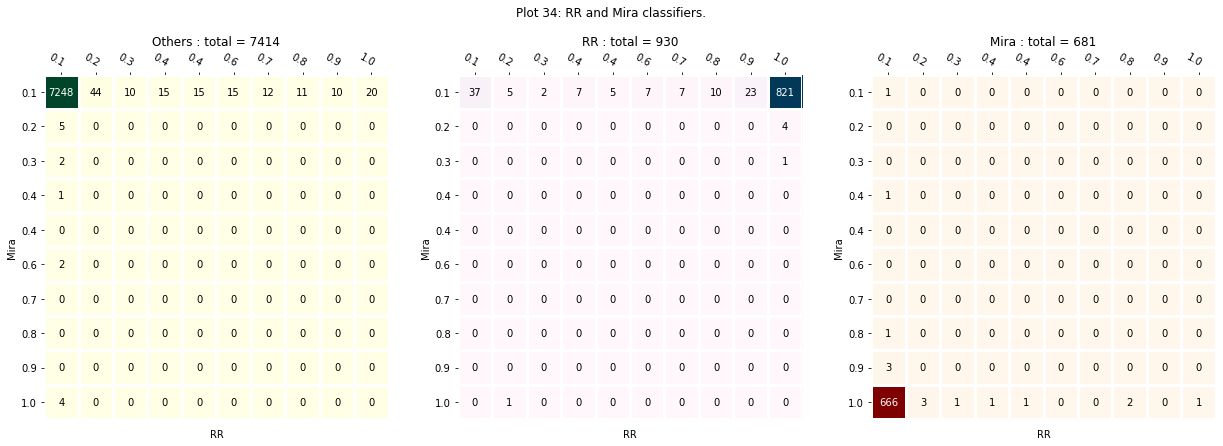

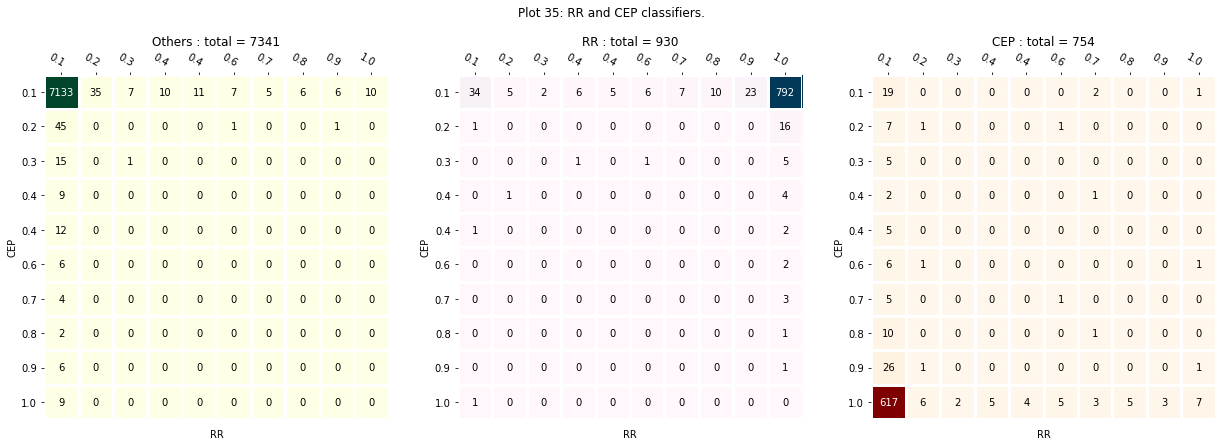

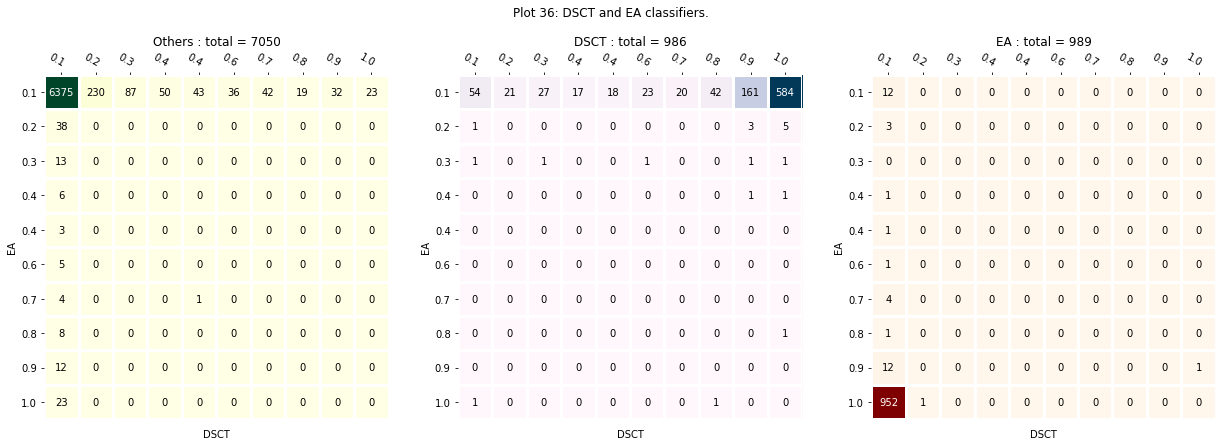

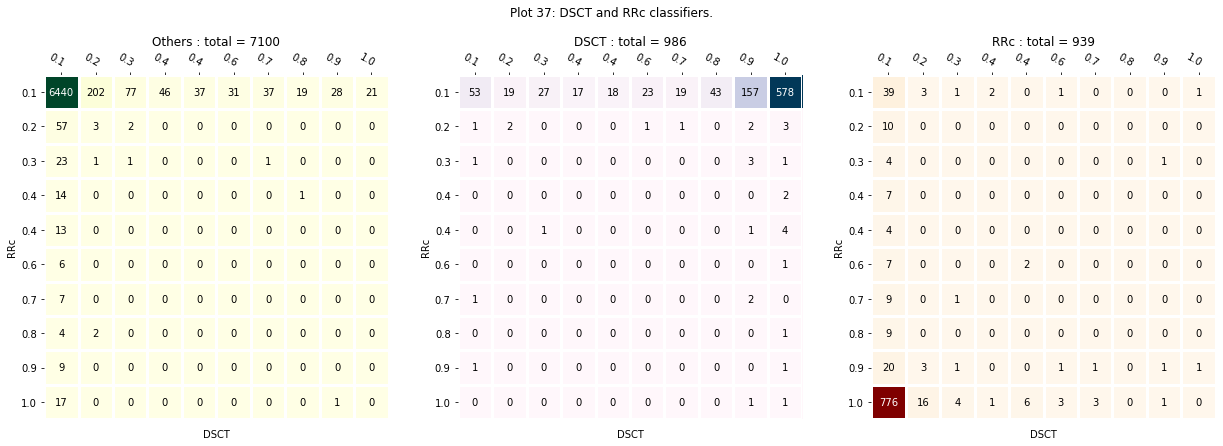

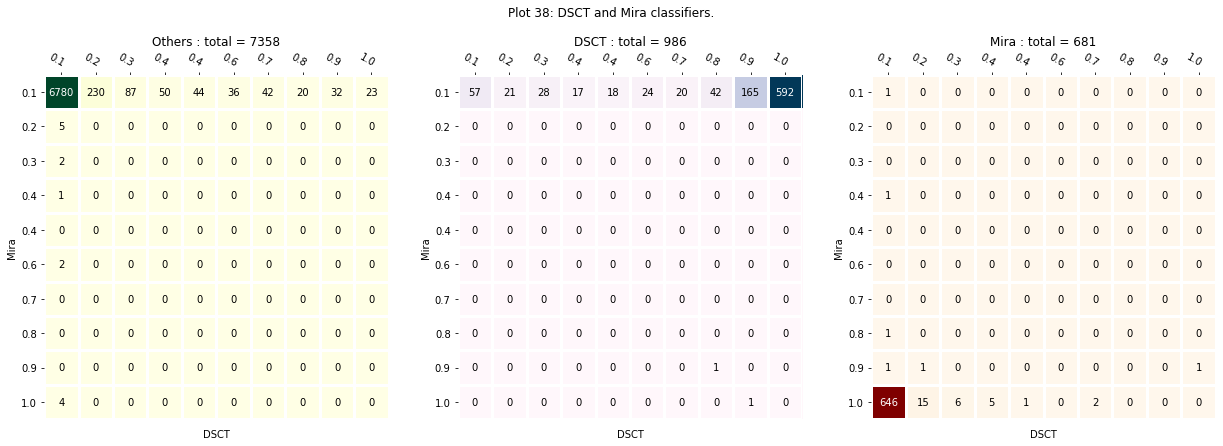

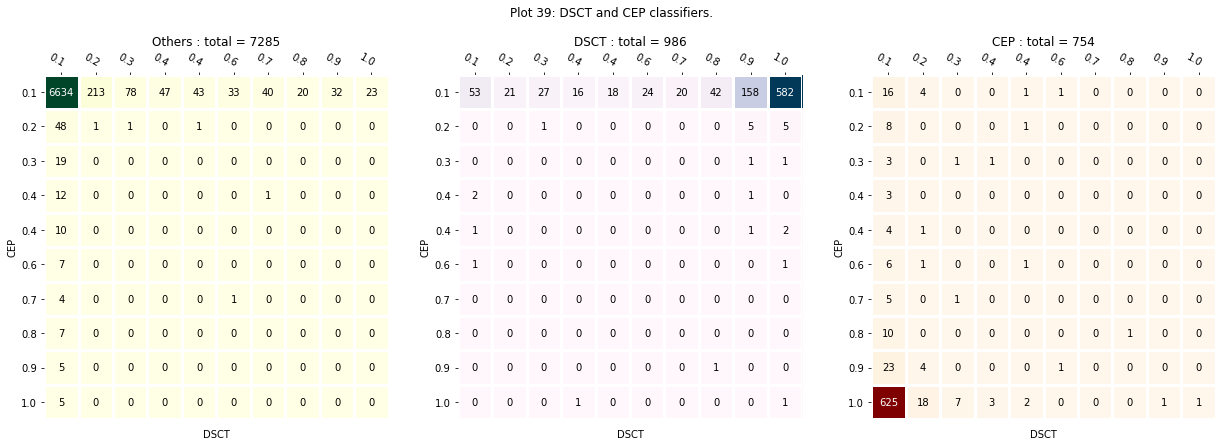

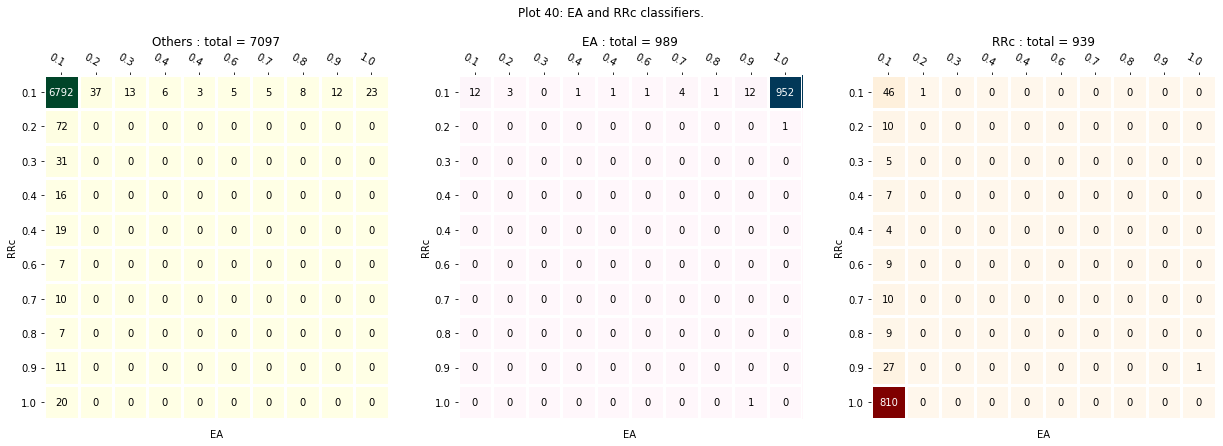

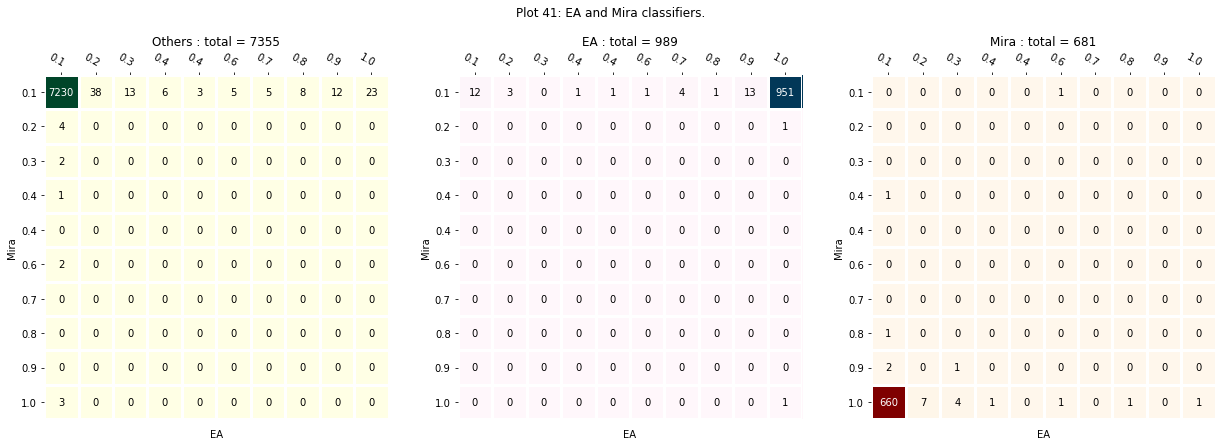

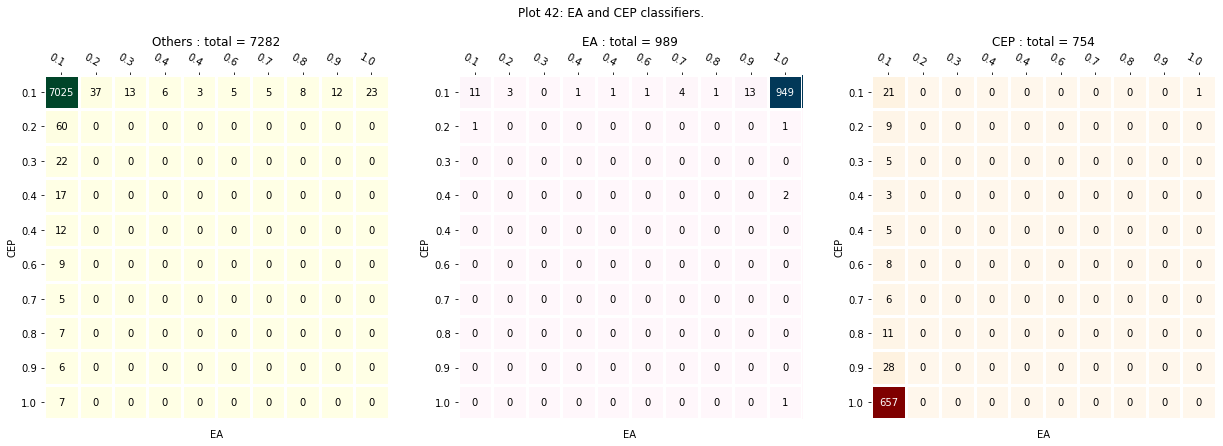

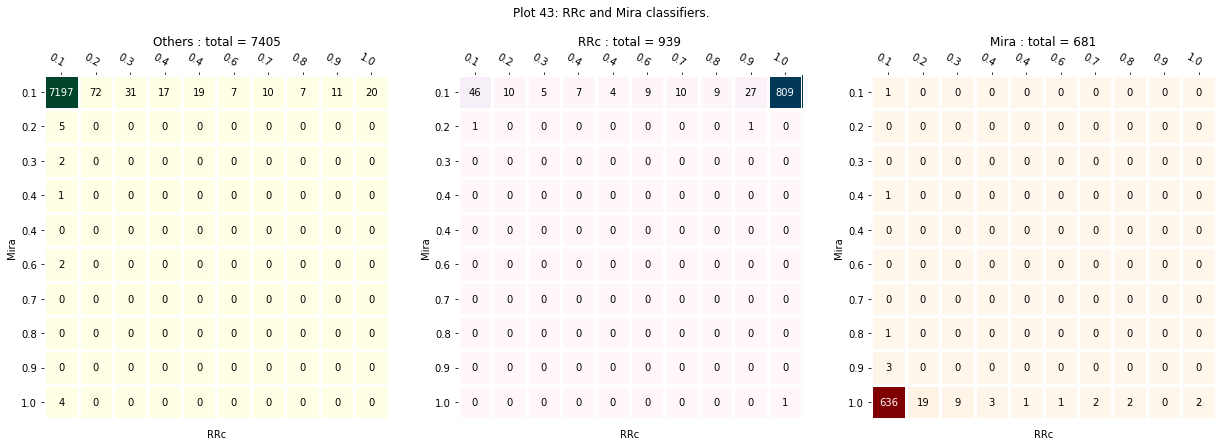

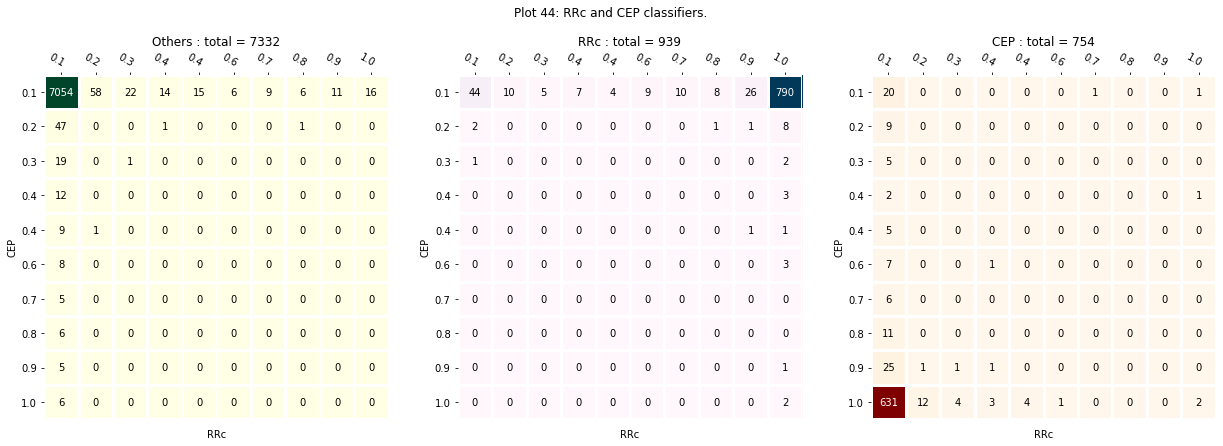

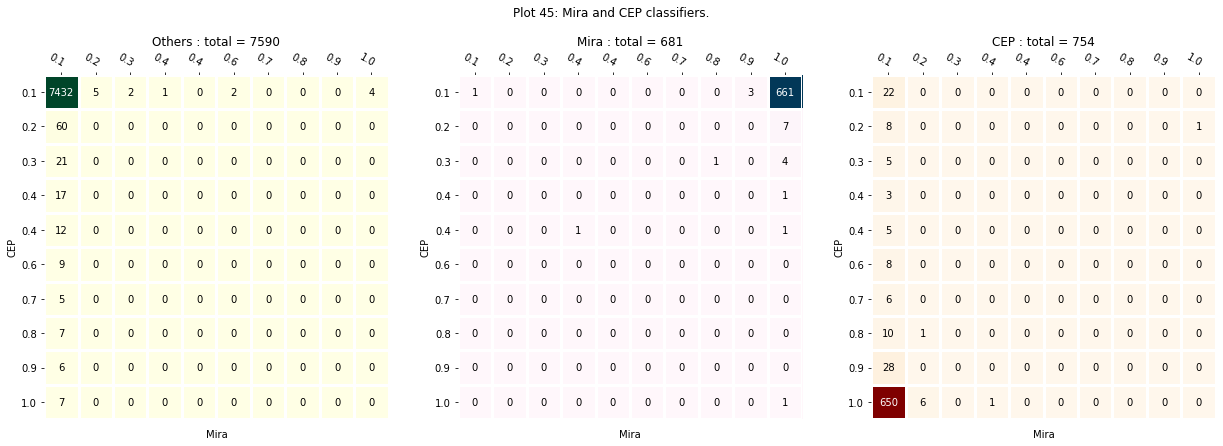

In [23]:
# plot the probabilities from 2 classifiers at a time using heatmap

n = len(label)
j = 0
for i in range(0,n):
    for k in range(i+1,n):
        j = j+1
        variable_type1 = label[i]
        variable_type2 = label[k]
        df_prob = pd.DataFrame(columns=[variable_type1, variable_type2, 'Type'])
        prob1 = all_probs[variable_type1][:,0]
        prob2 = all_probs[variable_type2][:,0]
        df_prob[variable_type1] = prob1
        df_prob[variable_type2] = prob2
        ind1 = df.index[df['Type']==variable_type1].values
        ind2 = df.index[df['Type']==variable_type2].values
        ind3 = df.index[(df['Type'] != variable_type1) & (df['Type'] != variable_type2)]
        
        
        df_prob.loc[ind1,'Type'] = variable_type1
        df_prob.loc[ind2,'Type'] = variable_type2
        df_prob.loc[ind3,'Type'] = 'Other' 
        
        title_string = "Plot {}: {} and {} classifiers.".format(j,variable_type1, variable_type2)
        xbins = ['0.1','0.2','0.3','0.4','0.4','0.6','0.7','0.8','0.9','1.0']
        ybins = ['0.1','0.2','0.3','0.4','0.4','0.6','0.7','0.8','0.9','1.0']
        
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(21,7))

        
        H, xedges, yedges = np.histogram2d(prob1[ind3],prob2[ind3], bins=(10,10))
        ax1.set_xlabel(variable_type1)
        ax1.set_ylabel(variable_type2)
        title = "Others : total = {}".format(len(prob1[ind3]))
        ax1.set_title(title)
        im = heatmap(H.T, ybins, xbins, ax=ax1,
                           cmap="YlGn", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        H, xedges, yedges = np.histogram2d(prob1[ind1],prob2[ind1], bins=(10,10))
        ax2.set_xlabel(variable_type1)
        ax2.set_ylabel(variable_type2)
        title = "{} : total = {}".format(variable_type1,len(prob1[ind1]))
        ax2.set_title(title)
        im = heatmap(H.T, ybins, xbins, ax=ax2,
                           cmap="PuBu", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        H, xedges, yedges = np.histogram2d(prob1[ind2],prob2[ind2], bins=(10,10))
        ax3.set_xlabel(variable_type1)
        ax3.set_ylabel(variable_type2)
        title = "{} : total = {}".format(variable_type2,len(prob1[ind2]))
        ax3.set_title(title)
        im = heatmap(H.T, ybins, xbins, ax=ax3,
                           cmap="OrRd", cbarlabel="")
        texts = annotate_heatmap(im, valfmt="{x:n}")
        
        fig.suptitle(title_string)
#         fig.tight_layout()
        plt.show()

        

In [24]:
# Run loop to train all optimized XGB classifier 10 times and collect average metrics in a dataframe
accuracy ={}
precision = {}
recall = {}
confusion ={}


# create comparision dataframe
header = pd.MultiIndex.from_product([clf_names,
                                     ['acc.','preci.','recall']],
                                    names=['classifier','metric(avg)'])
index_label = label
pd_comparison = pd.DataFrame(data=None, index=index_label, columns=header, dtype=None, copy=False)

# train models and collect metrics on test data
for variable_type in label: #loop over different types of variable stars
    print(variable_type)
    for p in range(1,11): # train each classification 10 times for each variable type
        df0, df_balanced = multiple_to_2labels(df,variable_type)
        X_train, X_test, y_train, y_test = preprocess_data(df_balanced)
        """
        Train Classifier using train dataset. Calculate classifier metrics using test dataset
        """
        #Train the model using the training sets
        model = pickle.loads(fitted_models['XGBoost'][variable_type])
        model.fit(X_train,y_train)

        # Predict test data output
        y_pred = model.predict(X_test)

        accuracy_int = metrics.accuracy_score(y_test, y_pred)
        confusion_int = metrics.confusion_matrix(y_test, y_pred)
        precision_int = metrics.precision_score(y_test, y_pred)
        recall_int = metrics.recall_score(y_test, y_pred)
        
        # calculate average accuracy, precision and recall
        if p == 1:
            accuracy[variable_type] = 0
            precision[variable_type] = 0
            recall[variable_type] = 0
        accuracy[variable_type] = accuracy_int/p + accuracy[variable_type]*(p-1)/p
        precision[variable_type] = precision_int/p + precision[variable_type]*(p-1)/p
        recall[variable_type] = recall_int/p + recall[variable_type]*(p-1)/p
            
        confusion[variable_type] = confusion_int # save confusion only of the 10th iteration


BYDra
[21:20:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

RSCVN
[21:21:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the obj

EA
[21:21:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

CEP
[21:21:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objec

In [25]:
import scipy.stats as sd
import matplotlib.pyplot as plt
def bivariate_gaussian_fit(x , y, gridsize, levels, line_color, ax, ax_xlim, ax_ylim):
    """
    Routine to calculate bivariate gaussian fit to the prediction sensity 
    """
    xmin = x.min()

    xmax = x.max()

    ymin = y.min()

    ymax = y.max()
    
    X, Y = np.mgrid[xmin:xmax:gridsize*1j, ymin:ymax:gridsize*1j]
    
    positions = np.vstack([X.ravel(), Y.ravel()])

    values = np.vstack([x, y])

    kernel = sd.gaussian_kde(values,bw_method = .3)

    Z = np.reshape(kernel(positions).T, X.shape)
    
    cset = ax.contour(X, Y, Z, levels, colors = line_color)

    ax.clabel(cset, cset.levels, inline=True)
    
    ax.set_xlim(ax_xlim)

    ax.set_ylim(ax_ylim)

## Notes:
1. Each classifiers was trained on ~2000 balanced datapoints from a total data ~9000 points.
1. Each one vs all classifier had high accuracy, precision and recall (>80% or 90% in most cases) for XG Boost classifier
1. But when we compare how one classifier classifies data from other class using all 9000 data points there are plenty of mis-classification. More than 20% data which is mis-classfied if we consider a probability threshold of 0.5.
1. To improve classification we need to 
    1. Tune the model
    1. Add more features especially pertaining to period calculation
    1. Use more data
1. Preliminary exploration shows Tuning or adding more data doesnot give a big boost to increasing classification accuarcy. Add better features might help.